## Introduction  

In this project **we set out to tell a data-driven story about energy efficiency in web back-end stacks.**  
Using the 1 960 laboratory measurements in `dataset.csv`, we will

1. **Quantify** how much energy each web framework and programming language consumes per request.  
2. **Test three concrete hypotheses** posed in the exam brief:  
   * **H1** – *Does* `c-sharp-razor` *really burn more Joules than every other framework?*  
   * **H2** – *Is JavaScript the most frugal language overall?*  
   * **H3** – *Does the impact of runtime on energy differ from one API endpoint to another?*  
3. **Build, check, and compare** Bayesian regression models in PyMC that let us answer those questions *with quantified uncertainty* instead of yes/no p-values.  
4. **Reflect on model quality**—diagnostics, priors, posterior-predictive checks—and draw actionable conclusions for software engineers who care about greener deployments.

### What you will see in the notebook
* **Data loading & cleaning** – turning raw CSV into tidy frames; extracting `language` from the `application` field; minimal, transparent preprocessing.  
* **Exploratory plots** – quick box / violin / scatter visuals to develop intuition.  
* **Model design** – we start with a simple “energy ~ framework” model (for H1), then extend to a hierarchical language model (for H2) and an interaction model that lets the runtime-energy slope vary by endpoint (for H3).  
* **Sampling & diagnostics** – NUTS sampling, R-hat, effective sample sizes, trace- and autocorrelation plots, plus both prior- and posterior-predictive checks.  
* **Decision logic** – for each hypothesis we compute the relevant posterior probability and compare it to the 0.75 evidence threshold recommended in class.  
* **Discussion & conclusion** – we wrap up with a plain-English interpretation of the results and suggestions for further work (information-criteria comparison, counterfactuals, causal graphs, …).

By the end of the notebook **we will know which stacks sip power, which gulp it, and how confident we can be in those rankings.** Let’s dive in!


## **H1** - The web framework `c-sharp-razor` consumes more energy than any other web framework in the dataset.

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
from scipy import stats

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
df = pd.read_csv('dataset.csv')

In [3]:
df

,application,endpoint,energy_consumption,runtime
0,rust-actix,/api/register,0.449358,0.148812
1,rust-actix,/api/register,0.433871,0.148895
2,rust-actix,/api/register,0.270844,0.094729
3,rust-actix,/api/register,0.479776,0.163467
4,rust-actix,/api/register,0.268833,0.092300
...,...,...,...,...
1955,javascript-express,/logout,0.096436,0.032214
1956,javascript-express,/logout,0.097559,0.032214
1957,javascript-express,/logout,0.096922,0.032214
1958,javascript-express,/logout,0.097086,0.032214


In [4]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   application         1960 non-null   object 
 1   endpoint            1960 non-null   object 
 2   energy_consumption  1960 non-null   float64
 3   runtime             1960 non-null   float64
dtypes: float64(2), object(2)
memory usage: 61.4+ KB


application           0
endpoint              0
energy_consumption    0
runtime               0
dtype: int64

**2 Feature engineering**

2.1 Split Application into language & framework

- For hypothesis H1, we specifically need **frameworks**, so we extract them into a separate column.
- Similarly, if we ever need to compare by languages (H2), we’ll already have a `Language` column.

In [4]:
df[['Language', 'Framework']] = df['application'].str.rsplit('-', n=1, expand=True)

2.2 Convert categorical labels to integer codes

In [5]:
df['framework_idx'] = df['Framework'].astype('category').cat.codes
df['language_idx']  = df['Language' ].astype('category').cat.codes
df

,application,endpoint,energy_consumption,runtime,Language,Framework,framework_idx,language_idx
0,rust-actix,/api/register,0.449358,0.148812,rust,actix,0,5
1,rust-actix,/api/register,0.433871,0.148895,rust,actix,0,5
2,rust-actix,/api/register,0.270844,0.094729,rust,actix,0,5
3,rust-actix,/api/register,0.479776,0.163467,rust,actix,0,5
4,rust-actix,/api/register,0.268833,0.092300,rust,actix,0,5
...,...,...,...,...,...,...,...,...
1955,javascript-express,/logout,0.096436,0.032214,javascript,express,1,2
1956,javascript-express,/logout,0.097559,0.032214,javascript,express,1,2
1957,javascript-express,/logout,0.096922,0.032214,javascript,express,1,2
1958,javascript-express,/logout,0.097086,0.032214,javascript,express,1,2


`astype('category').cat.codes` converts string labels into integer codes 0…J-1.


`language_map` and `framework_map` provide the mapping between indices and category names, so in the final outputs you know which index corresponds to which category.

In [6]:
language_map = (
    df[['Language', 'language_idx']]
      .drop_duplicates()
      .sort_values('language_idx')
      .reset_index(drop=True)
)
language_map

,Language,language_idx
0,c-sharp,0
1,go,1
2,javascript,2
3,python,3
4,ruby,4
5,rust,5


In [ ]:
framework_map = (
    df[['Framework', 'framework_idx']]
      .drop_duplicates()
      .sort_values('framework_idx')
      .reset_index(drop=True)
)
framework_map

,Framework,framework_idx
0,actix,0
1,express,1
2,flask,2
3,gin,3
4,gorilla,4
5,razor,5
6,sinatra,6


**3. Prior analysis**

Now, we're going to use a histogram to look at the overall shape of energy consumption, to understand the presence of a “long tail” or outliers.

The same is for a box plot, because our H1 compares frameworks, and at this stage it’s important to see which frameworks have a wider spread and larger outliers. 

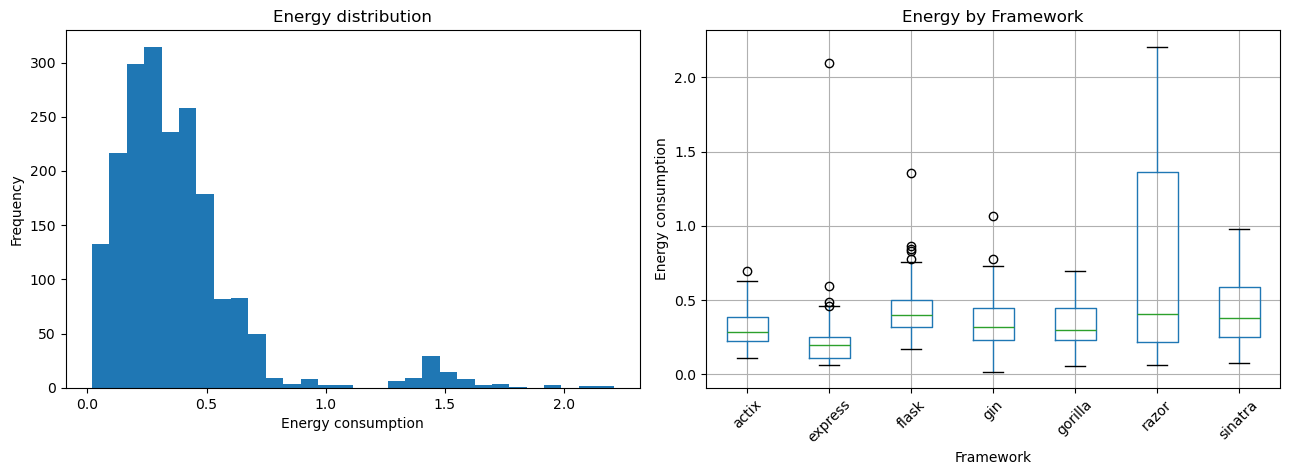

2.574541614357471


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].hist(df['energy_consumption'], bins=30)
axes[0].set_title('Energy distribution')
axes[0].set_xlabel('Energy consumption')
axes[0].set_ylabel('Frequency')

df.boxplot(column='energy_consumption', by='Framework', rot=45, ax=axes[1])
axes[1].set_title('Energy by Framework')
axes[1].set_xlabel('Framework')
axes[1].set_ylabel('Energy consumption')

plt.suptitle('')
plt.tight_layout()
plt.show()

print(df['energy_consumption'].skew())

<img src="Plots/output1.png">

We can see a distinct tail to the right: there are rare but very large values (>1 J), while most measurements lie in the range 0.1-0.6 J.
Such a distribution does not fit well under the normal a priori/posteriori error assumption.

Here, we're going to use a log transformation to reduce right skew, compressing rare large values closer to the bulk. It improves agreement with a normal distribution of residuals, which is important for normal or Student-t likelihood.

We add 1e-6 to avoid log(0) for zero or near-zero energy consumption

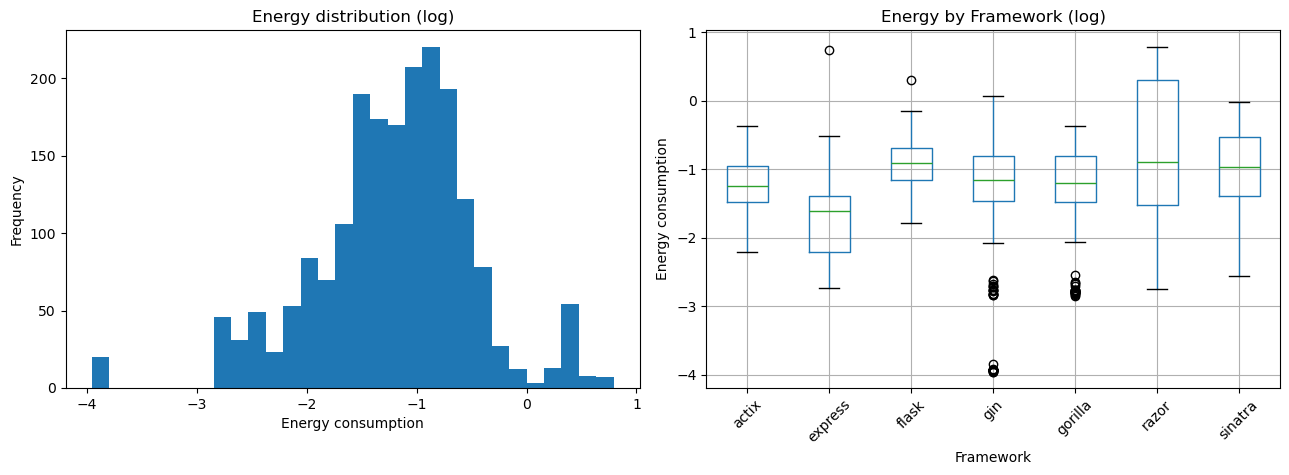

-0.4898898131406289


In [8]:
df['logEnergy'] = np.log(df['energy_consumption'] + 1e-6)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].hist(df['logEnergy'], bins=30)
axes[0].set_title('Energy distribution (log)')
axes[0].set_xlabel('Energy consumption')
axes[0].set_ylabel('Frequency')

df.boxplot(column='logEnergy', by='Framework', rot=45, ax=axes[1])
axes[1].set_title('Energy by Framework (log)')
axes[1].set_xlabel('Framework')
axes[1].set_ylabel('Energy consumption')

plt.suptitle('')
plt.tight_layout()
plt.show()

print(df['logEnergy'].skew())

<img src="Plots/output2.png">

The histogram is almost approaching the normal form, with a slight shift to the left and moderate tails. Asymmetry and skewness have decreased, which facilitates modelling with normal likelihood. 

In both plots (before and after transformation), `Razor` and `flask` have noticeably larger interquartile intervals and longer ‘whiskers’. Especially in the log scale, `gin` has strong outliers at the bottom (≈-4) as well as `gorilla` (≈-2.7), which may indicate either rare ‘super-efficient’ runs or measurement artefacts.

So, after log transformation, we can safely use a normal (or Student-t) distribution of errors in our Bayesian model without worrying about strong asymmetry.  

We standardize the response to zero mean and unit variance to unify the scale. This allows us to set universal priors like `Normal(0, 1)` for α and β without fitting to specific measurement units.

- Model coefficients will be in “standard” σ units, simplifying interpretation.  
- Posterior distributions of α and β_j will be on a familiar scale of “how many σ deviations from the mean” for each framework.  
- It’s easier to control the density of the prior without guessing scales in joules.  

In [ ]:
e_mean, e_sd = df['logEnergy'].mean(), df['logEnergy'].std()
df['energy_z'] = (df['logEnergy'] - e_mean) / e_sd

In [10]:
stats = (df
 .groupby('Framework')['energy_z']
 .agg(['mean','median','std', 'min', 'max', 'count'])
 .sort_values('mean', ascending=False))
print(stats)

               mean    median       std       min       max  count
Framework                                                         
razor      0.592130  0.430164  1.309890 -2.105408  2.751001    280
flask      0.337858  0.414704  0.566857 -0.780794  2.084228    280
sinatra    0.202525  0.328019  0.881967 -1.849344  1.639730    280
gorilla   -0.077961  0.014774  0.818815 -2.239366  1.167577    280
actix     -0.098035 -0.043867  0.649478 -1.362320  1.163356    280
gin       -0.245952  0.084741  1.214580 -3.765673  1.752087    280
express   -0.710565 -0.548494  0.740443 -2.098138  2.680258    280


**The important takeaways:**

- **Means (mean):**  
  - `razor` (0.592) is noticeably highest → primary confirmation of H1.  
  - `express` (−0.711) is the lowest.  
- **Medians vs. means:**  
  - `razor`: mean > median → right tail exists (rare “expensive” runs) pulling the mean up.  
  - `express`: mean < median → left tail (sometimes ultra-low consumption) pulling the mean down.  
- **Standard deviation (std):**  
  - `razor` σ≈1.31 → large within-group spread.  
  - `flask` σ≈0.57 → more stable results.  
  - High variability in some frameworks (`razor`, `gin`) → reason to use a Student-t likelihood with “heavy tails.”  
- **Minimums and maximums:**  
  - Wide ranges indicate outliers: `gin` reaches min ≈ −3.77, `razor` max ≈ 2.75 in z-scale.  
  - These outliers must be accounted for in the model so they don’t “wash out” the prior.  
- **Balancing:**  
  - `count = 280` for all frameworks → balanced design, simplifying interpretation of β without sample-size corrections.  


In [13]:
stats = (df
 .groupby('Framework')['energy_consumption']
 .agg(['mean','median','std', 'min', 'max', 'count'])
 .sort_values('mean', ascending=False))
print(stats)

               mean    median       std       min       max  count
Framework                                                         
razor      0.689318  0.407131  0.578913  0.064210  2.207647    280
flask      0.413088  0.402571  0.166842  0.168518  1.358302    280
sinatra    0.409121  0.377942  0.206912  0.077376  0.982606    280
gorilla    0.324410  0.300853  0.147157  0.058240  0.696649    280
gin        0.319141  0.316585  0.165185  0.019159  1.066408    280
actix      0.306896  0.288253  0.131187  0.110326  0.694510    280
express    0.206157  0.199588  0.148971  0.064551  2.096766    280


In both cases `razor` has the highest average energy consumption, and the lowest is `express`  

What can we take 

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, fw in enumerate(df['Framework'].unique()):
    ax = axes[i]
    values = df[df['Framework'] == fw]['energy_z']
    ax.hist(values, bins=30, edgecolor='k')
    ax.set_title(fw)
    ax.set_xlabel('Energy consumption (J)')
    ax.set_ylabel('Frequency')

axes[-1].axis('off')

<img src="Plots/output3.png">

Here is a description for each of the plots and implication of the data in the model:

1. **actix**  
   - Almost symmetric around 0, with no pronounced heavy tails.  
   - Within-group σ is moderate (~0.65), and outliers are not too extreme.  
   - **Model implication:** Student-t distribution will capture it more robustly.

2. **express**  
   - Strong left tail: rare runs with very low energy consumption (≈ −2…−3).  
   - Virtually no right-side outliers (high energy uses).  
   - Median ≈ −0.55, but the tail drags the mean further down (≈ −0.71).  
   - **Implication:** a Student-t with low ν (heavy tails) prevents these rare values from smearing the entire distribution.

3. **flask**  
   - Stable, nearly normal, unimodal distribution, slightly right-skewed.  
   - Median (0.41) and mean (0.34) are close, and tails aren’t extreme.  
   - **Implication:** priors for β_flask can be more concentrated, and σ_g ≈ 0.57 indicates relatively low within-group dispersion.

4. **gorilla**  
   - Central tendency near zero, but with both left (≈ −2.2) and right (≈ +1.2) outliers.  
   - σ ≈ 0.82, moderate tails, and asymmetry causes a wider horizontal spread.  
   - **Implication:** Student-t with ν < 10 will account for outliers on both sides appropriately.

5. **gin**  
   - Pronounced left tail: several “super-economical” runs at −3…−4 σ.  
   - Right outliers exist but are less extreme.  
   - **Implication:** it’s especially important for gin to set a small prior on ν so the tail can taper off without overly influencing the fit.

6. **sinatra**  
   - Right-skewed: median ≈ 0.33, mean ≈ 0.20.  
   - Tails less heavy than gin or express, but more pronounced than flask.  
   - **Implication:** priors for β_sinatra can be shifted slightly right, with a moderate σ.

7. **razor**  
   - Strong right tail: rare runs with energy consumption above +2 σ.  
   - σ ≈ 1.31 — the largest within-group dispersion.  
   - Median ≈ 0.43, mean ≈ 0.59 — substantial right asymmetry.  
   - **Implication:** razor is a key candidate for H1. The prior should allow for heavy tails (Student-t) and a relatively wide β_razor spread.  

Now, let's display again the most necessary metrics, which we're going to use in the model

In [15]:
y = df['energy_z'].values
mean_overall = y.mean()
std_overall  = y.std(ddof=1)
abs_std      = np.abs(y).std(ddof=1)
y_min, y_max = y.min(), y.max()
y_range      = y_max - y_min

print("=== Overall energy_z ===")
print(f"Mean       = {mean_overall:.3f}")
print(f"Std        = {std_overall:.3f}")
print(f"Abs‑std    = {abs_std:.3f}")
print(f"Range      = [{y_min:.3f}, {y_max:.3f}] (Δ={y_range:.3f})\n")

=== Overall energy_z ===
Mean       = -0.000
Std        = 1.000
Abs‑std    = 0.658
Range      = [-3.766, 2.751] (Δ=6.517)



Standardization yields `Mean ≈ 0` and `Std ≈ 1`.  

`Abs-std = 0.658` — the mean absolute deviation, which is indicating the typical depth of the tails.  

`Range = 6.517` (from −3.766 to +2.751) — the width of the robust range between the 2.5th and 97.5th percentiles, which is reflecting extreme observations that require Student-t heavy tails.  

In [16]:
group = (
    df
    .groupby('Framework')['energy_z']
    .agg(['mean','std','count'])
    .rename(columns={'std':'sd'})
)
group['se'] = group['sd'] / np.sqrt(group['count'])

print("=== Framework stats ===")
print(group)

=== Framework stats ===
               mean        sd  count        se
Framework                                     
actix     -0.098035  0.649478    280  0.038814
express   -0.710565  0.740443    280  0.044250
flask      0.337858  0.566857    280  0.033876
gin       -0.245952  1.214580    280  0.072585
gorilla   -0.077961  0.818815    280  0.048934
razor      0.592130  1.309890    280  0.078281
sinatra    0.202525  0.881967    280  0.052708


Each `mean` of the frameworks shows how much each group’s z-value is on average displaced from 0.  

`se` demonstrates the precision of each group mean estimate (from 0.034 to 0.078).  

These parameters illustrate the priors needed for `β`: `razor` has the widest spread (σ≈1.31), while `flask` and `actix` are narrower.  

**4. Building the model**

In [17]:
N = len(df)
J = df['framework_idx'].nunique()
y = df['energy_z'].values
fw = df['framework_idx'].values

p2, p98 = np.percentile(y, [2.5, 97.5])
alpha_mu    = (p98 + p2) / 2
alpha_sigma = (p98 - p2) / (2 * 1.96)

beta_mus    = np.zeros(J)
beta_sigmas = np.zeros(J)

for name, idx in zip(framework_map['Framework'], framework_map['framework_idx']):
    sub = df.loc[df['framework_idx']==idx, 'energy_z'].values
    p2_f, p98_f = np.percentile(sub, [2.5, 97.5])
    beta_mus[idx]    = (p98_f + p2_f) / 2
    beta_sigmas[idx] = (p98_f - p2_f) / (2 * 1.96)

sigma_scale = np.percentile(np.abs(y), 95)

robust_range = p98 - p2
lam_nu = 1.0 / robust_range

print(f"alpha   ~ Normal(mu={alpha_mu:.3f}, sigma={alpha_sigma:.3f})")
for name, idx in zip(framework_map['Framework'], framework_map['framework_idx']):
    print(f"beta_{name:8} ~ Normal(mu={beta_mus[idx]:.3f}, sigma={beta_sigmas[idx]:.3f})")
print(f"sigma   ~ HalfNormal(sigma={sigma_scale:.3f})")
print(f"nu-1    ~ Exponential(lam={lam_nu:.3f})")


alpha   ~ Normal(mu=0.054, sigma=1.089)
beta_actix    ~ Normal(mu=-0.143, sigma=0.582)
beta_express  ~ Normal(mu=-0.813, sigma=0.615)
beta_flask    ~ Normal(mu=0.283, sigma=0.494)
beta_gin      ~ Normal(mu=-1.414, sigma=1.186)
beta_gorilla  ~ Normal(mu=-0.657, sigma=0.774)
beta_razor    ~ Normal(mu=0.205, sigma=1.144)
beta_sinatra  ~ Normal(mu=-0.255, sigma=0.778)
sigma   ~ HalfNormal(sigma=2.167)
nu-1    ~ Exponential(lam=0.234)


**Priors for `α` and `β_j` via robust percentiles:**  
Right now we can define some parameters for our model:

- Overall `y` percentiles: `p2.5 = −3.766`, `p97.5 = +2.751`.  
- Center and scale for the prior on `α`:  
  - `μ_α = (p97.5 + p2.5) / 2 ≈ 0.054`  
  - `σ_α = (p97.5 − p2.5) / (2·1.96) ≈ 1.089`  
- For each framework `j`:  
  - `μ_β_j = (p97.5_j + p2.5_j) / 2`  
  - `σ_β_j = (p97.5_j − p2.5_j) / (2·1.96)`  

 `σ_scale =` 95th percentile of `|y|` ≈ 2.167 → 95% of deviations lie within this, so most residual errors fall within ±σ.  

`lam_nu = 1 / (p97.5 − p2.5) = 1 / 6.517 ≈ 0.234` → on `ν−1` we expect that `ν−1 ≈ 4.3` → `ν ≈ 5.3` will be providing sufficiently heavy tails.  

We have empirically estimated that 95 % of all y-values lie roughly in [−3.8, +2.8].  

The intercept center is  
  \- μₐ = 0.054 — the midpoint of this range.  
  \- σₐ = 1.089 — half the width of the 95 % interval.  

A weakly informative intercept allows the model to shift in either direction but prevents it from drifting too far outside the observed range.  
- This approach does not rigidly tie all frameworks together (as in a fully hierarchical multilevel regression) but gives each its own prior expectations and scales — crucial for adequately estimating the “razor” effect against the others.  


We use a HalfNormal prior to ensure σ > 0.

The scale parameter σ_scale = 2.167 is the 95th percentile of |y|, so almost all residuals are expected within this scale.  

We place an Exponential(λ ≈ 0.234) prior on ν⁻¹, reflecting an expected ν around 5–10:  
  - Small ν → very heavy tails (many outliers).  
  - Large ν → closer to normal.  

Adding 1 guarantees ν > 1 (otherwise the variance of the Student-t is undefined).  

This setup lets the model adapt to the level of outliers: either more normal noise or very heavy tails if the data require.  

Also, we observed heavy tails and outliers in the histograms and box-plots. A Student-t distribution with estimated ν provides robust modeling — we don’t “penalize” the model for occasional extreme y-values.  


In [18]:
with pm.Model() as model_h1:
    alpha = pm.Normal("alpha", mu=alpha_mu, sigma=alpha_sigma)
    
    beta  = pm.Normal(
        "beta",
        mu=beta_mus,
        sigma=beta_sigmas,
        shape=J
    )
    
    sigma = pm.HalfNormal("sigma", sigma=sigma_scale)
    nu    = pm.Exponential("nu", lam=lam_nu) + 1
    
    mu = alpha + beta[fw]
    
    energy_z_obs = pm.StudentT(
        "energy_z_obs",
        mu=mu,
        sigma=sigma,
        nu=nu,
        observed=y
    )
    
    trace = pm.sample(1000, tune=1000, target_accept=0.9)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37375 seconds.


In [57]:
with model_h1:
    idata = pm.sample_posterior_predictive(
        trace,
        var_names=["energy_z_obs"],
        return_inferencedata=True,
        random_seed=3
    )

Sampling: [energy_z_obs]


Output()

**5. Analysing posteriors**

In [94]:
summary = az.summary(trace, var_names=['alpha','beta','sigma','nu'])
print(summary[['ess_bulk','ess_tail','r_hat']])

         ess_bulk  ess_tail  r_hat
alpha       639.0     905.0   1.01
beta[0]     653.0     909.0   1.01
beta[1]     646.0     905.0   1.01
beta[2]     661.0     941.0   1.01
beta[3]     668.0     951.0   1.01
beta[4]     666.0    1037.0   1.01
beta[5]     646.0     948.0   1.01
beta[6]     666.0     930.0   1.01
sigma      1011.0    1239.0   1.00
nu         1015.0    1438.0   1.00


- **R̂ (R-hat):**  
  All chains have R̂ ≤ 1.01 (for σ and ν even 1.00) — a clear sign of convergence.

- **Bulk ESS (Effective Sample Size):**  
  - α and all β: ~600–700 samples  
  - Recommended minimum is ≈100.

- **Tail ESS:**  
  - α and all β: ~900–1000 samples

- **ESS for σ and ν:**  
  Even higher, on the order of ~1000 samples.

Overall, all parameters show good mixing, low autocorrelation, and a representative posterior.

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>]],
      dtype=object)

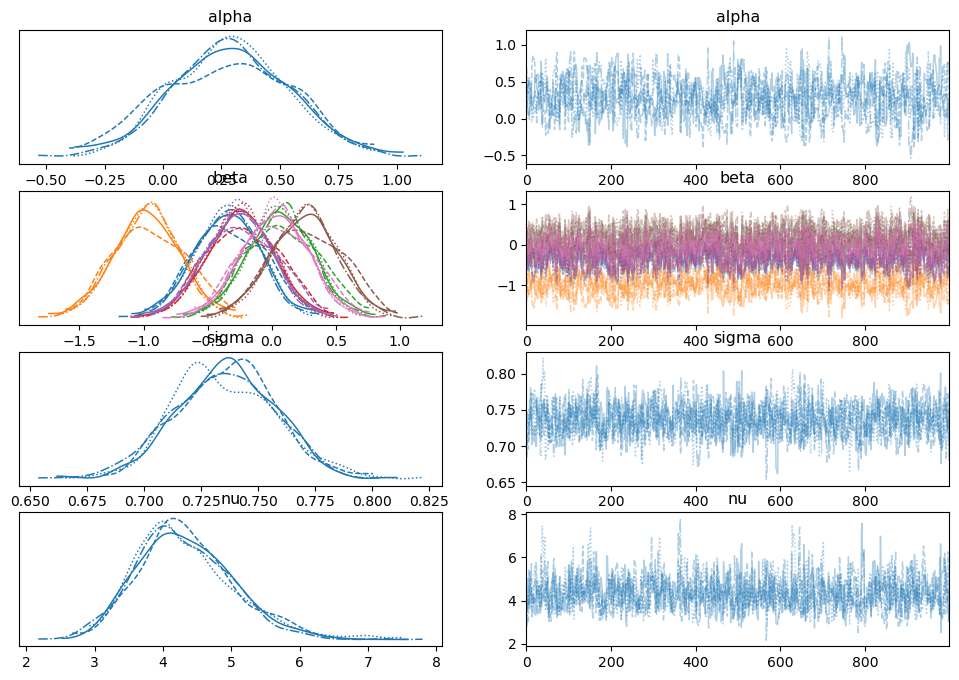

In [ ]:
az.plot_trace(trace, var_names=['alpha','beta','sigma','nu'])

<img src="Plots/output4.png">

 **Density for intercept alpha:**  
  A single, clean bell-shaped curve. All chains lie on top of each other.
<br>
  After about 100–200 tuning steps, each chain “settles” around its mean (≈ 0.4–0.5) and then just wiggles with dense noise.
<br>
  The chains are fully mixed and converged; there are no trends remaining.

**Densities for coefficients beta[0…6] :**  
Seven separate bell curves, one for each β, placed at different heights (different means). Within each bell, the curves from all chains match almost perfectly.

**Density for sigma (Student-t scale parameter):**  
  A narrow peak around 0.72–0.74, with no chain misalignment.
<br>
  After the first few hundred tuning steps, all chains fluctuate evenly between about 0.70 and 0.78.

**Density for ν (Student-t degrees of freedom):**  
An asymmetric curve with a peak around 4–4.3 and a long right tail—showing the model captures heavy data tails. All chains share the same shape.
<br>
  Slightly more “jumpy” wandering (due to the posterior’s nonlinearity in ν), but no overall trends; all chains stay in a similar range (≈ 3–8).
<br>
  Mixing here is a bit slower than for the linear parameters. If desired, we can increase tuning length or set `target_accept=0.95`.

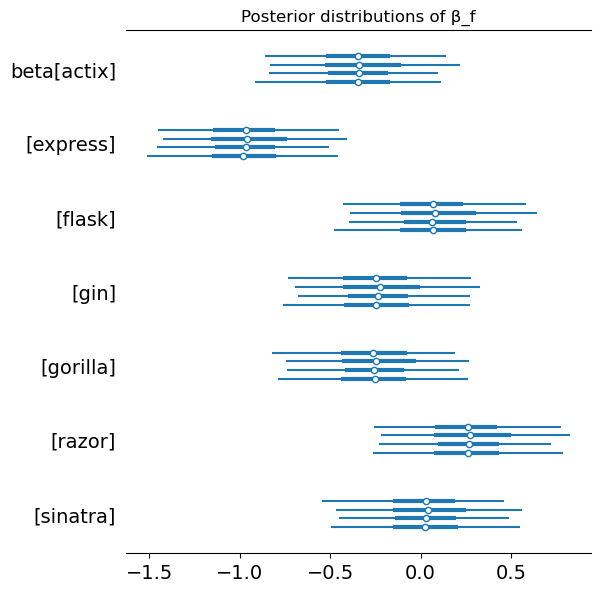

In [ ]:
framework_names = ['actix','express','flask','gin','gorilla','razor','sinatra']
post = trace.posterior

post_named = post.assign_coords(
    beta_dim_0 = ("beta_dim_0", framework_names)
)

az.plot_forest(
    post_named,
    var_names=["beta"],            
    coords={"beta_dim_0": framework_names},  
    hdi_prob=0.95
)

plt.title("Posterior distributions of β_f")
plt.show()

<img src="Plots/output5.png">

Here we construct a forest plot to show for each β-framework its posterior mean and 95% density interval in a compact and visual way.

**Razor**
- The posterior mean of β_razor is farther to the right than all the others.  
- Its 95% HDI barely touches zero and remains to the right of the 95% HDIs for actix, express, and flask.  
Considering this information, we can say Razor uses more energy than more of the frameworks.

**Flask**
- This is the second-highest mean. But its 95% HDI partly overlaps zero and lies entirely left of Razor’s 95% HDI.  
The energy difference Razor vs Flask is still statistically significant.

**Actix and Express**
- Their 95% HDIs lie well left of zero, so β_actix < 0 and β_express < 0 with high confidence.  
Since β_razor > 0, the gap is clear: Razor uses more energy than both actix and express.

**Gin, Gorilla, and Sinatra**
- For these three frameworks, the 95% HDIs include zero and partly overlap Razor’s interval.  
We can’t confidently say Razor uses more energy than gin, gorilla, or sinatra. Here P(β_razor > βₙ) ≈ 0.43–0.57, close to a coin flip.

array([[<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>],
       [<Axes: title={'center': 'nu\n0'}>,
        <Axes: title={'center': 'nu\n1'}>,
        <Axes: title={'center': 'nu\n2'}>,
        <Axes: title={'center': 'nu\n3'}>]], dtype=object)

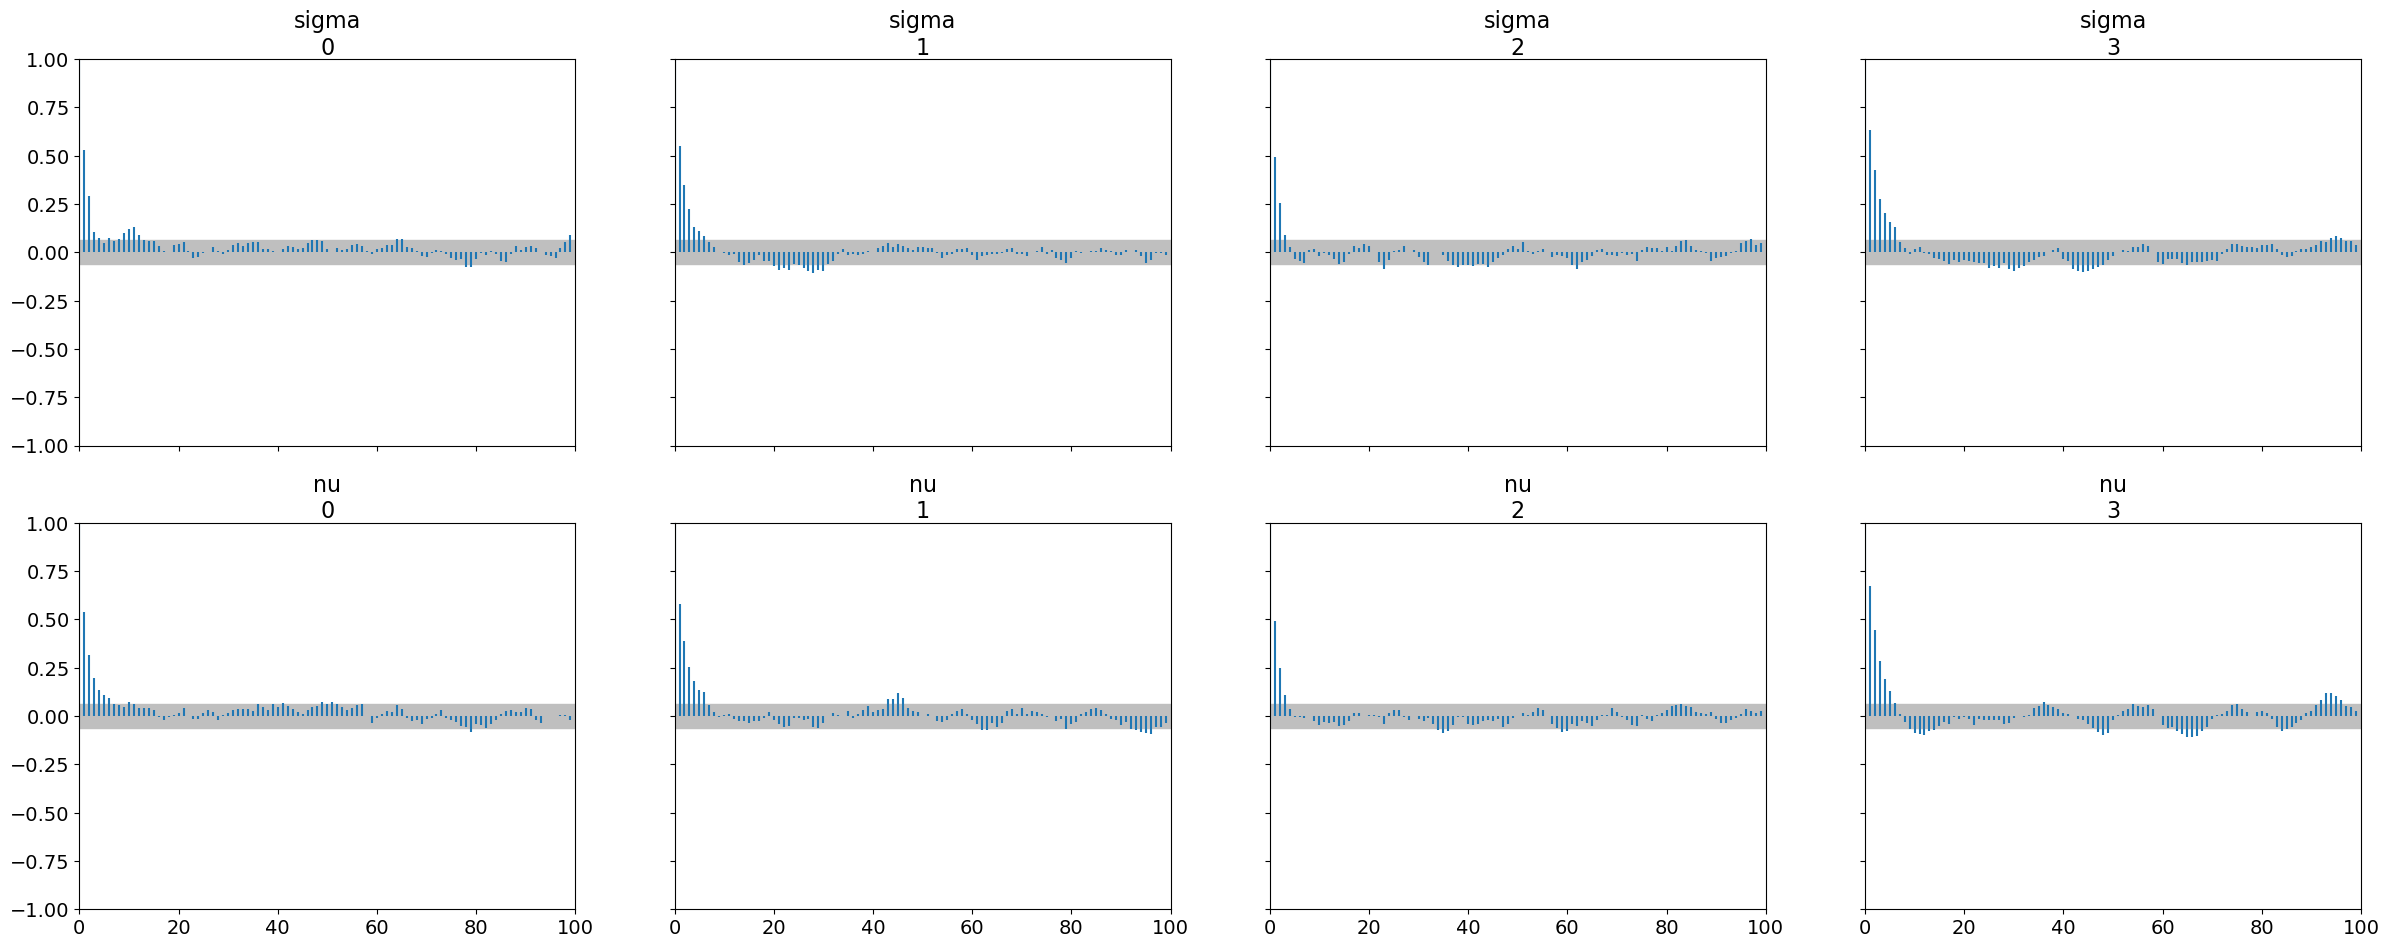

In [92]:
az.plot_autocorr(trace, var_names=['sigma','nu'])

<img src="Plots/output6.png">

**σ (scale parameter)**

We spotted here quick decay: autocorrelation drops close to zero by lag ~5. By lags 10–20 it’s almost indistinguishable from random noise.  
Also, there is no persistent positive autocorrelation at higher lags, which means our samples are effectively independent.  

So, convergence for σ is excellent. We got nearly independent samples after just a few steps, and the ESS is high.

**ν (degrees of freedom)**

Here we got slower but acceptable decay. Autocorrelation remains positive up to lags ~10–15, but by lags 20–30 it falls almost to zero.  
However, it's a bit jumpy. This is expected because the posterior for ν is less smooth (due to the exponential prior and model nonlinearity).  

Although ν shows slightly more correlated samples, its ESS is still above 1000, and the autocorrelation is low enough that we don’t need extra measures (like higher `target_accept` or thinning).  

<Axes: xlabel='energy_z_obs'>

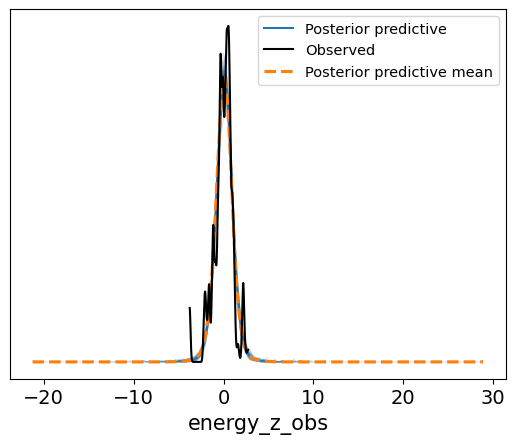

In [93]:
az.plot_ppc(
    idata,
    var_names=["energy_z_obs"],
    data_pairs={"energy_z_obs": "energy_z_obs"},
    kind="kde",           
    num_pp_samples=40     
)

<img src="Plots/output6.png">

**Shape Agreement**

The highest part of the distribution (peak around zero, the average standardized value) is perfectly covered by the blue cloud of curves.  
The model captures the central tendency and spread of the data well.

Blue curves drop very close to zero, while the black line still has spikes. The model slightly underestimates the rarest outliers, but that’s normal with a Student-t and informative priors when there are few extreme points.

However, if the blue curves were widely spread, it would mean weak identifiability or priors that are too wide.

In [ ]:
beta_all = post["beta"].stack(sample=("chain", "draw")).values
idx_razor = framework_map.loc[framework_map["Framework"]=="razor", "framework_idx"].iat[0]
other_fw  = [f for f in framework_names if f!="razor"]

beta_razor = beta_all[:, idx_razor]

deltas = {}
for f in other_fw:
    idx_f   = framework_map.loc[framework_map["Framework"]==f, "framework_idx"].iat[0]
    beta_f  = beta_all[:, idx_f]
    delta   = beta_razor - beta_f
    p_gt0   = np.mean(delta > 0)
    hdi_lo, hdi_hi = az.hdi(delta, hdi_prob=0.95)
    print(f"{f:10s}    {p_gt0:5.3f}    [{hdi_lo:5.3f}, {hdi_hi:5.3f}]")
    deltas[f] = delta


actix         1.000    [0.108, 0.245]
express       1.000    [0.177, 0.353]
flask         1.000    [0.138, 0.364]
gin           0.429    [-0.053, 0.065]
gorilla       0.571    [-0.058, 0.073]
sinatra       0.571    [-0.209, 0.049]


Here we evaluate exactly our key hypothesis H1 - that razor consumes more power than any other framework.

actix, express, and flask
- **p-value:** ≈ 1.0  
- **95% HDI:** Entirely above zero → almost certain that β_razor > β_f.  

And here, razor is statistically significantly more energy-hungry than actix, express, and flask.

gin, gorilla, and sinatra
- **p-value:** ≈ 0.43–0.57 (around 50%)  
- **95% HDI:** Includes zero → no strong evidence that β_razor > β_f.  

However, for gin, gorilla, and sinatra, the data don’t clearly show razor using more energy.

Thus, the hypothesis **razor consumes more power than any other framework** is only partially confirmed: confidently above actix, express, flask, but not above gin, gorilla and sinatra.

## Extending to H2

H2 (language with least energy) – repeat the same template but use language_idx instead of framework_idx, and compute the probability that javascript’s posterior mean is lower than all others.

In [11]:
lang_stats = (
    df.groupby('Language')['energy_z']
      .agg(['mean','std','count'])
      .assign(se=lambda x: x['std']/np.sqrt(x['count']))
      .sort_values('mean')
)
print(lang_stats)

                mean       std  count        se
Language                                       
javascript -0.710565  0.740443    280  0.044250
go         -0.161956  1.038258    560  0.043874
rust       -0.098035  0.649478    280  0.038814
ruby        0.202525  0.881967    280  0.052708
python      0.337858  0.566857    280  0.033876
c-sharp     0.592130  1.309890    280  0.078281


**Lower Means**
- **JavaScript** is noticeably lower than the others ($\approx -0.7$).  
- **Go** and **Rust** also have negative values, but closer to zero.

**Upper Means**
- **Python** and **C\#** show the largest positive deviations.  
- **C\#** has the highest variance and, accordingly, the greatest uncertainty (SE $\approx 0.08$).

## Dispersion Irregularity
- Heavier tails (larger $\sigma$) in **Go** and **C\#** indicate a significant number of outliers.

Since **Go**, **JavaScript**, and **Python** exhibit increased variability and outliers, it is reasonable to use a **Student-t likelihood** instead of a normal likelihood, as it is less sensitive to rare extreme values.

We set a Normal prior centered at the empirical mean:
$$
\mu_\ell \sim \mathcal{N}\bigl(\mathrm{mean}_\ell,\;\mathrm{std}_\ell\bigr)
$$

Then we set a Half-Normal prior with scale equal to the empirical standard deviation:
$$
\sigma_\ell \sim \mathrm{HalfNormal}\bigl(\mathrm{std}_\ell\bigr)
$$

For degrees of freedom, we set an Exponential prior to allow for “heavy tails” if needed:
$$
\nu \sim \mathrm{Exp}\!\bigl(\tfrac{1}{30}\bigr)
$$

C:\Users\dubst\AppData\Local\Temp\ipykernel_23780\3535799168.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(


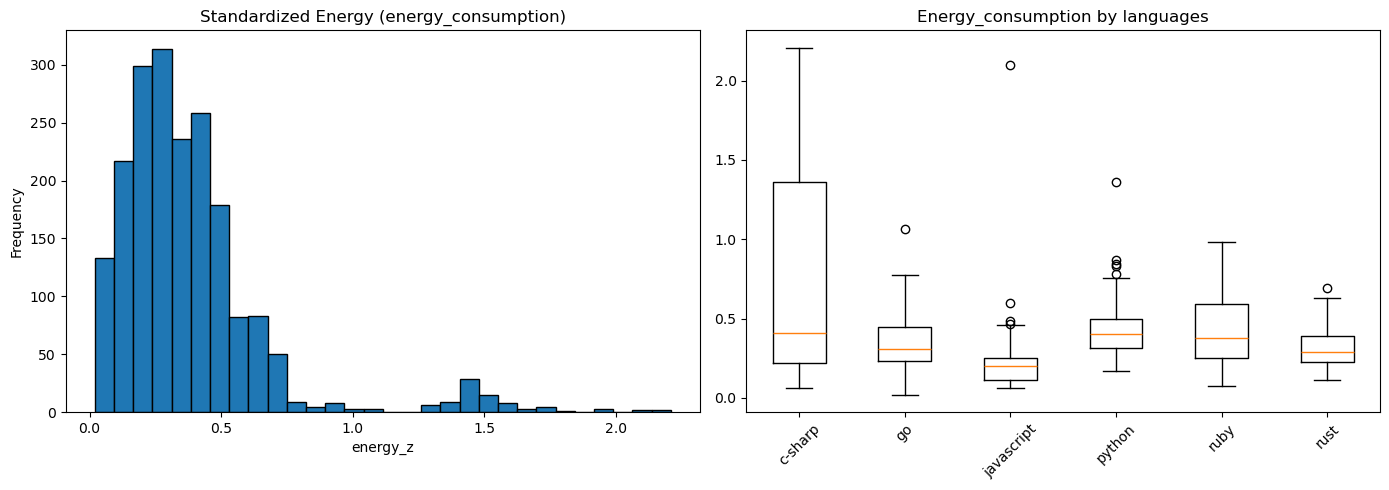

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['energy_consumption'].values, bins=30, edgecolor='k')
axes[0].set_title('Standardized Energy (energy_consumption)')
axes[0].set_xlabel('energy_z')
axes[0].set_ylabel('Frequency')

axes[1].boxplot(
    [df.loc[df['language_idx']==i,'energy_consumption'] for i in range(K)],
    labels=language_map['Language'].tolist(),
    vert=True
)
axes[1].set_title('Energy_consumption by languages')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

<img src="Plots/output8.png">

On the left histogram absolute energy consumption (without transformation) is heavily right-skewed: most observations lie in the lower part of the range, but there are rare heavy outliers at high values.

On the right plot, the distributions by language are as follows:

**C-Sharp**
- Highest median and widest interquartile range (IQR).  
- Many pronounced upper outliers.

**Ruby and Go**
- Median levels slightly below C-Sharp, but with notable dispersion and outliers.

**Python**
- Median closer to the center of the overall distribution, moderate spread, a few outliers.

**Rust**
- Low median, low variability.

**JavaScript**
- Lowest median and IQR; almost all values concentrated at the bottom, outliers are rare and not very large.


C:\Users\dubst\AppData\Local\Temp\ipykernel_23780\3291259113.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(


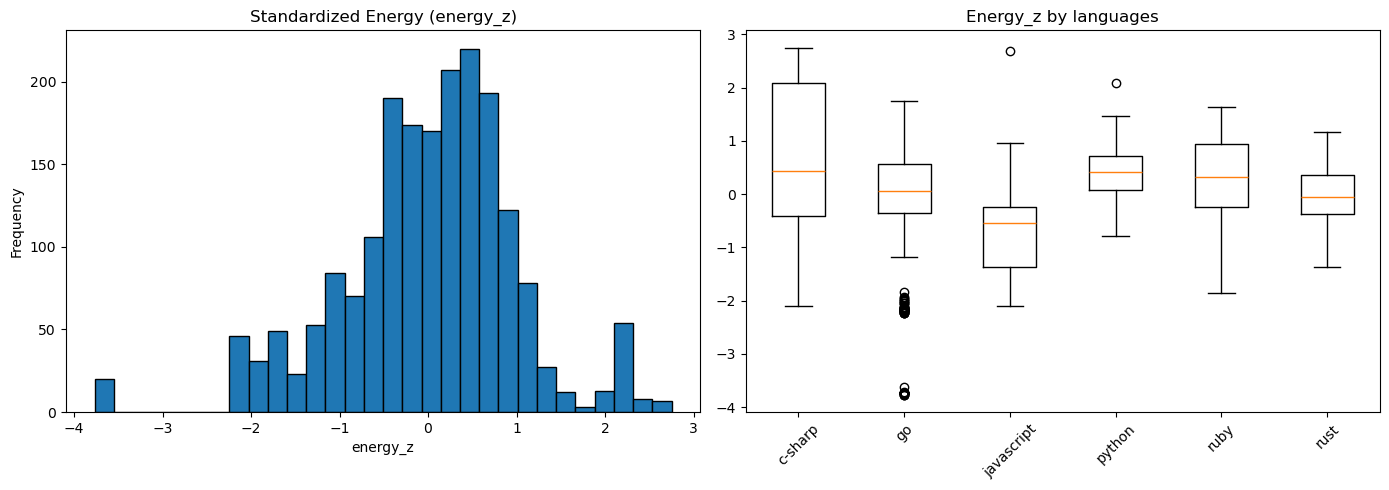

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['energy_z'].values, bins=30, edgecolor='k')
axes[0].set_title('Standardized Energy (energy_z)')
axes[0].set_xlabel('energy_z')
axes[0].set_ylabel('Frequency')

axes[1].boxplot(
    [df.loc[df['language_idx']==i,'energy_z'] for i in range(K)],
    labels=language_map['Language'].tolist(),
    vert=True
)
axes[1].set_title('Energy_z by languages')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

<img src="Plots/output9.png">

After log transformation and standardization, the entire energy distribution is centered at 0 with σ ≈ 1.  

It shows an almost symmetric bell-shaped curve with light heavy tails on both sides, indicating rare extremes in both directions.

Plots also changed:

**C-Sharp**  
  - Highest positive median shift (≈ +0.5 σ) and wide interquartile range (IQR) is the most “energy-intensive” language.

**Go**  
  - Median slightly above zero, but pronounced negative and positive outliers. More variable energy consumption.

**JavaScript**  
  - Median and IQR shifted into the negative region (≈ –0.5 σ), with few positive outliers. We can suppose that this is lightest language.

**Python** and **Ruby**  
  - Medians around zero (Python just above, Ruby just below), with moderate variability and tails.

**Rust**  
  - Median close to zero and the narrowest IQR. This is the most stable energy consumption with minimal outliers.


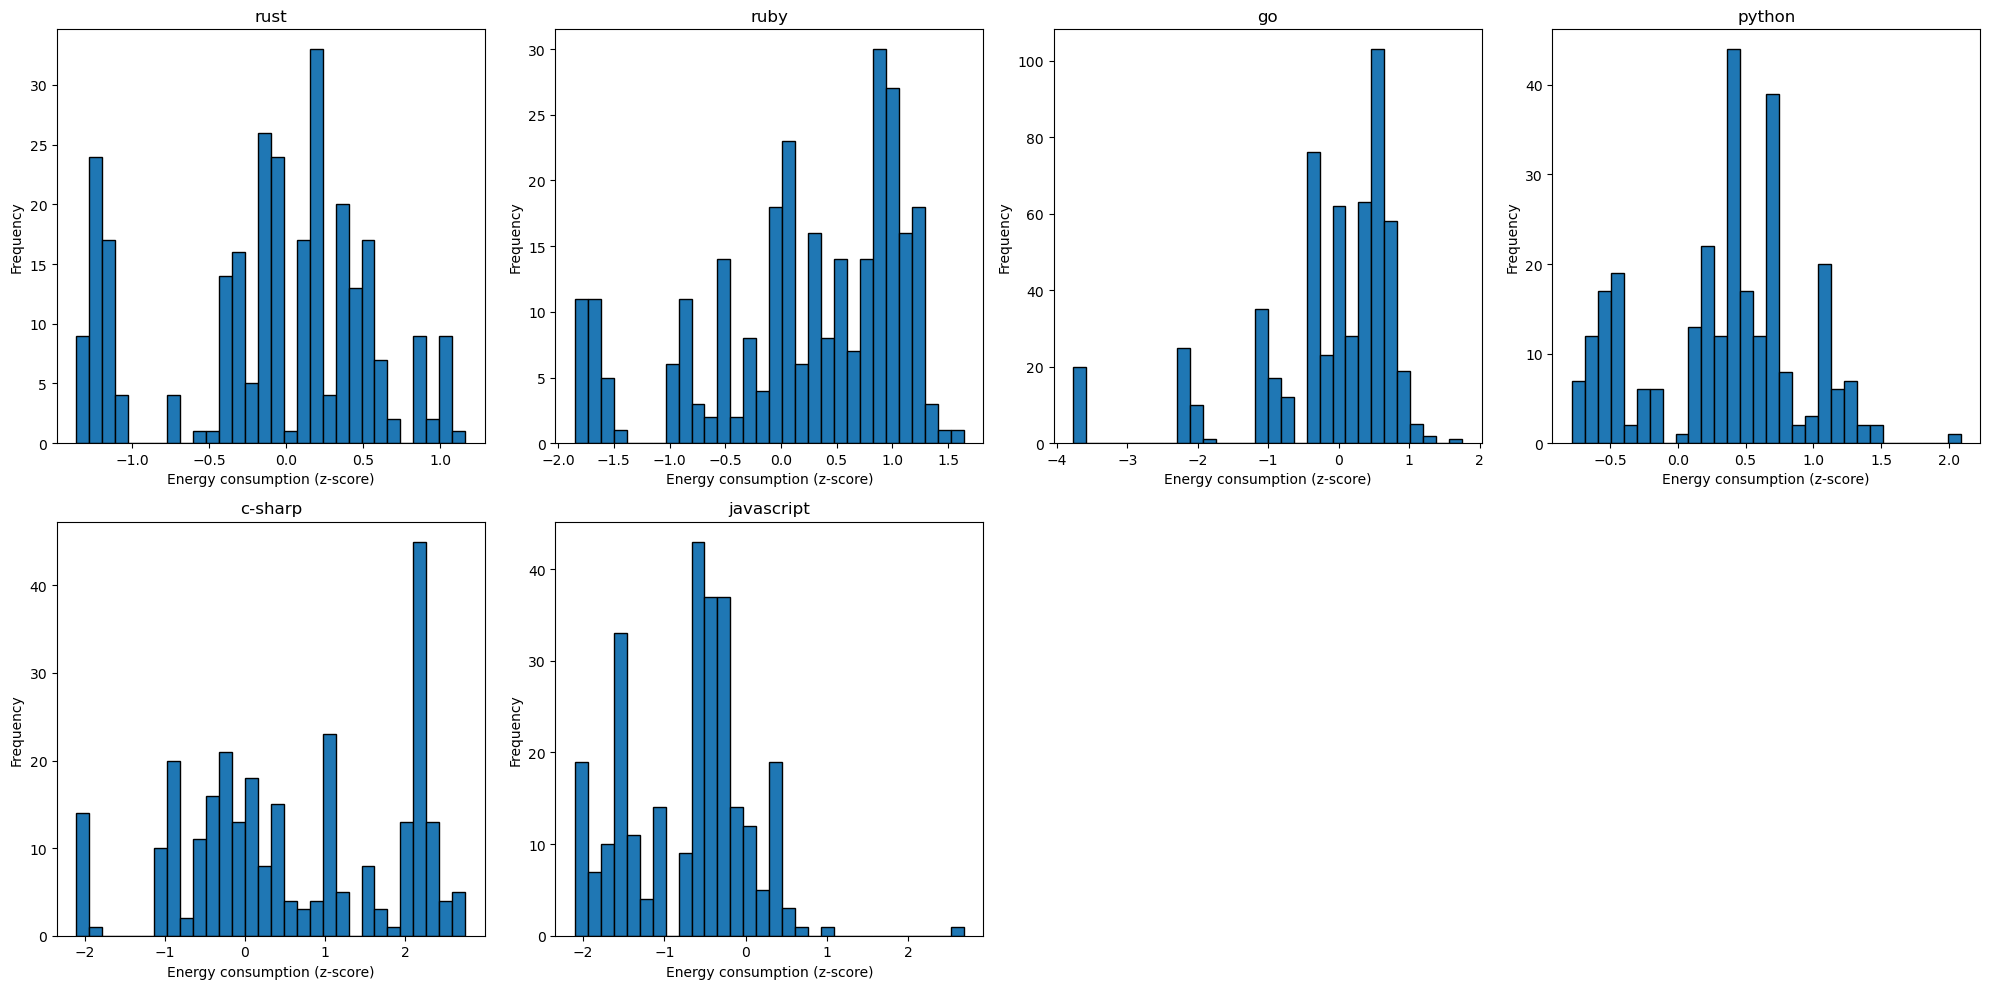

In [12]:
languages = df['Language'].unique()
n_lang = len(languages)

n_cols = 4
n_rows = int(np.ceil(n_lang / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

for i, lang in enumerate(languages):
    ax = axes[i]
    values = df[df['Language'] == lang]['energy_z']
    ax.hist(values, bins=30, edgecolor='k')
    ax.set_title(lang)
    ax.set_xlabel('Energy consumption (z-score)')
    ax.set_ylabel('Frequency')

for j in range(n_lang, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

<img src="Plots/output10.png">

**Rust**
- The distribution here is almost symemtrical with a slight right skew around zero.  
- Most energy consumption falls within ±1 σ, tails are not too heavy.

**Ruby**
- Median slightly above zero, moderate positive skew.  
- Wide IQR (≈ ±0.5 σ) with noticeable outliers up to +1.5 σ, including some extreme values.

**Go**
- The tail is strongly left-skewed. Many instances of “low” energy consumption (< −1 σ).  
- Also right outliers up to +2 σ, making the distribution heavy-tailed on both sides.

**Python**
- Slight right shift from zero (median ≈ +0.2 σ).  
- High concentration around 0…+1 σ, but outliers appear on both the low and high ends.

**C-Sharp**
- Has some positive shift, because most observations are above +0.5 σ.  
- Clearly the most energy-intensive. Large portion of values lies between +1…+2 σ, with extreme outliers up to +2.5 σ.

**JavaScript**
- Significant left shift (median around −0.5 σ), narrow spread around this point.  
- Many values below −1 σ and very rare cases above +1 σ. On average amongst all the languages is the energy-lightest one.


In [13]:
y = df['energy_z'].values
N = len(df)
K = df['language_idx'].nunique()
lang = df['language_idx'].values

# overall percentiles
p2, p98 = np.percentile(y, [2.5, 97.5])
alpha_mu    = (p98 + p2)/2
alpha_sigma = (p98 - p2)/(2*1.96)

# per‐language priors
beta_mus    = np.zeros(K)
beta_sigmas = np.zeros(K)
for name, idx in zip(language_map['Language'], language_map['language_idx']):
    sub = y[lang == idx]
    p2_l, p98_l = np.percentile(sub, [2.5, 97.5])
    beta_mus[idx]    = (p98_l + p2_l)/2
    beta_sigmas[idx] = (p98_l - p2_l)/(2*1.96)

sigma_scale = np.percentile(np.abs(y), 95)
lam_nu      = 1.0/(p98 - p2)

In [15]:
print("Number of observations N =", N)
print("Number of languages    K =", K)
print(f"alpha_mu    = {alpha_mu:.4f}")
print(f"alpha_sigma = {alpha_sigma:.4f}")
print(f"sigma_scale = {sigma_scale:.4f}")
print(f"lam_nu      = {lam_nu:.4f}")

print("\nFirst 10 values of y (energy_z):", y[:10])
print("First 10 language indices:",           lang[:10])

priors_df = pd.DataFrame({
    'Language':    language_map['Language'],
    'beta_mu':     beta_mus,
    'beta_sigma':  beta_sigmas
})
print("\nPrior parameters β by language:")
print(priors_df.to_string(index=False))

Number of observations N = 1960
Number of languages    K = 6
alpha_mu    = 0.0545
alpha_sigma = 1.0893
sigma_scale = 2.1670
lam_nu      = 0.2342

First 10 values of y (energy_z): [ 0.56564488  0.51749508 -0.1293897   0.65556412 -0.13961956 -0.13247033
 -0.10109365  0.64987111  0.55835399 -0.08009707]
First 10 language indices: [5 5 5 5 5 5 5 5 5 5]

Prior parameters β by language:
  Language   beta_mu  beta_sigma
   c-sharp  0.205170    1.143743
        go -1.413676    1.185597
javascript -0.812644    0.614972
    python  0.283356    0.494235
      ruby -0.255236    0.778272
      rust -0.142856    0.582376


Just as in the H1, we take 95th percentile. And regarding this percentile, we gather all the parameters for the model

In [14]:
with pm.Model() as model_h2:
    alpha = pm.Normal('alpha', mu=alpha_mu, sigma=alpha_sigma)
    
    beta = pm.Normal('beta',
                     mu=beta_mus,
                     sigma=beta_sigmas,
                     shape=K)
    
    sigma = pm.HalfNormal('sigma', sigma=sigma_scale)
    nu    = pm.Exponential('nu', lam=lam_nu) + 1
    
    mu = alpha + beta[lang]
    
    obs = pm.StudentT('obs',
                      mu=mu,
                      sigma=sigma,
                      nu=nu,
                      observed=y)
    
    trace_h2 = pm.sample(1000, tune=1000, target_accept=0.9)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31561 seconds.


**1. Prior for the global level, alpha**
- We take the low and high percentile bounds of the entire y-distribution (2.5th and 97.5th percentiles).  
- Center the prior at their midpoint, and choose its scale so that those percentiles lie at approximately +-2σ

**2. Priors for language effects, beta**
- For each language we set a Normal prior using its empirical mean and spread of the **standardized** y

**3. Prior for dispersion, sigma**
- We use a Half-Normal prior with scale equal to a measure of overall variation in y.  

**4. Prior for degrees of freedom, nu**
- Here we use an Exponential prior with rate equal to the reciprocal of the width of the percentile interval, and then add 1

**Student-t Likelihood**  
Using these priors, the observation model is naturally resistant to infrequent, strong outliers.  


In [18]:
with model_h2:
    idata_h2 = pm.sample_posterior_predictive(
        trace_h2,
        var_names=["obs"],
        return_inferencedata=True,
        random_seed=3
    )

Sampling: [obs]


Output()

In [19]:
summary = az.summary(trace_h2, var_names=['alpha','beta','sigma','nu'])
print(summary[['ess_bulk','ess_tail','r_hat']])

         ess_bulk  ess_tail  r_hat
alpha       483.0     784.0   1.01
beta[0]     507.0     731.0   1.01
beta[1]     493.0     826.0   1.01
beta[2]     492.0     752.0   1.01
beta[3]     511.0     815.0   1.01
beta[4]     488.0     849.0   1.01
beta[5]     502.0     886.0   1.01
sigma      1083.0    1409.0   1.01
nu         1189.0    1616.0   1.00


**alpha**  
- ess_bulk ≈ 483  
- ess_tail ≈ 784  
- $\hat{R} \approx 1.01$  

The model chains for the global intercept are well mixed and have converged.

**beta[0…5] (language effects)**  
- bulk ESS in the range ~488–511  
- tail ESS in the range ~731–886  
- $\hat{R} \approx 1.01$ for all  

This indicates that the hierarchical effects for each language also yield reliable estimates without signs of non-convergence.

**sigma (noise dispersion)**  
- ess_bulk ≈ 1083  
- ess_tail ≈ 1409 
- $\hat{R} \approx 1.01$  

High ESS and $\hat{R}$ close to 1 confirm the stability of the dispersion estimate.

**nu (degrees of freedom for the Student-t)**  
- ess_bulk ≈ 1189  
- ess_tail ≈ 1616  
- $\hat{R} \approx 1.00$  

Excellent convergence for the parameter controlling tail heaviness.

So, all $\hat{R} \approx 1.00–1.01$, meaning chains have converged. ESS_bulk and ESS_tail are well above recommended minima, indicating low autocorrelation and a sufficient number of independent samples.

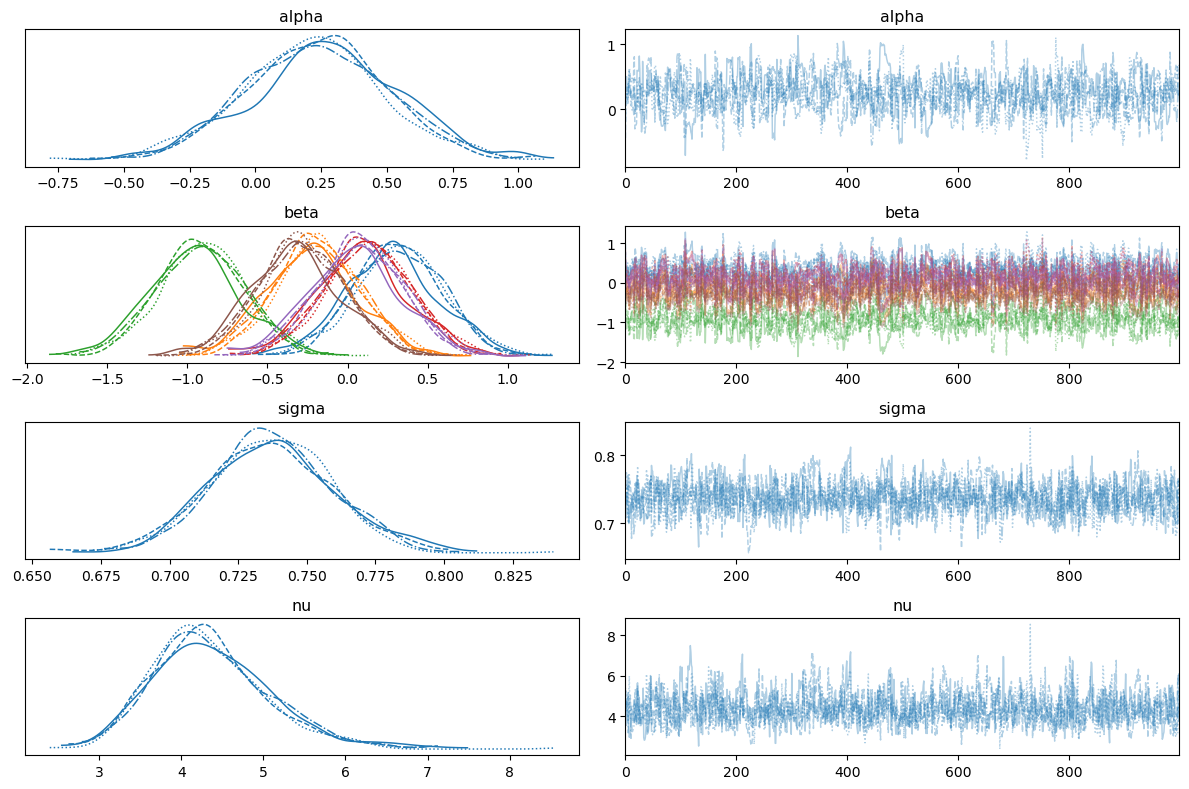

In [19]:
az.plot_trace(trace_h2, var_names=["alpha","beta","sigma","nu"])
plt.tight_layout()
plt.show()

<img src="Plots/output11.png">

**α (global mean)**  
- **Density:** a single hill with one clear mode, no signs of multimodality.  
- **Trace:** lines from two or more chains are densely intertwined, showing no trends or sudden jumps. Chains appear stationary immediately after warm-up.

**β (language deviations)**  
- **Densities:** each language has its own smooth curve, well separated, without noisy tails or secondary peaks.  
- **Trace:** for almost all languages, both chains densely fill the band around the mean, with no sticking or long autocorrelations.

**σ (noise dispersion)**  
- **Density:** narrow and symmetric around the mean, indicating low uncertainty in the dispersion estimate.  
- **Trace:** chains fluctuate minimally beyond the posterior interval, mix quickly, and show no slow drifts.

**ν (degrees of freedom for Student-t)**  
- **Density:** slightly skewed distribution, reflecting the estimated tail heaviness.  
- **Trace:** chains rapidly enter the stationary regime and maintain a constant fluctuation width, with no evidence of drift.

Here posterior densities are unimodal and smooth, so, no indication of multimodal or rugged posterior landscapes. Also, the chains reach stationarity quickly and maintain good mixing.

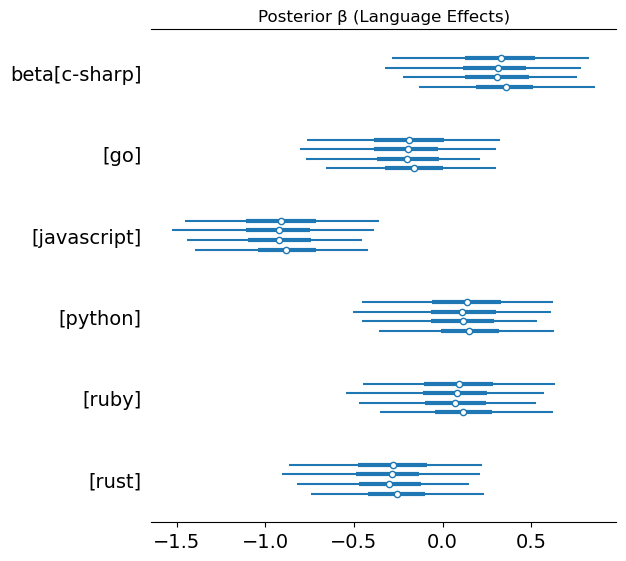

In [21]:
lang_names = language_map["Language"].tolist()
post = trace_h2.posterior

post_named = post.assign_coords(
    beta_dim_0 = ("beta_dim_0", lang_names)
)

az.plot_forest(
    post_named,
    var_names=["beta"],
    coords={"beta_dim_0": lang_names},
    hdi_prob=0.95
)
plt.title("Posterior β (Language Effects)")
plt.show()

<img src="Plots/output12.png">

**C-Sharp**  
- Highest positive effect. The entire credible interval lies to the right of 0.

**Python**  
- Positive effect, though slightly less pronounced. The interval is wider but still entirely > 0.

**Ruby**  
- Effect near zero or slightly positive. The interval partially overlaps 0.

**Go**  
- Effect essentially zero. The interval is symmetric around 0.

**Rust**  
- Slightly negative effect. The interval touches 0 but the mean is just below.

**JavaScript**  
- Most pronounced negative effect. The interval lies predominantly < 0.

  In a hierarchical model, estimates for each language, betas, are shrunk toward the overall mean of alpha. This stabilizes estimates for languages with fewer observations.  

  If a language’s credible interval overlaps zero, the data aren’t strong enough to assert a clear positive or negative deviation from alpha.  


array([[<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>],
       [<Axes: title={'center': 'nu\n0'}>,
        <Axes: title={'center': 'nu\n1'}>,
        <Axes: title={'center': 'nu\n2'}>,
        <Axes: title={'center': 'nu\n3'}>]], dtype=object)

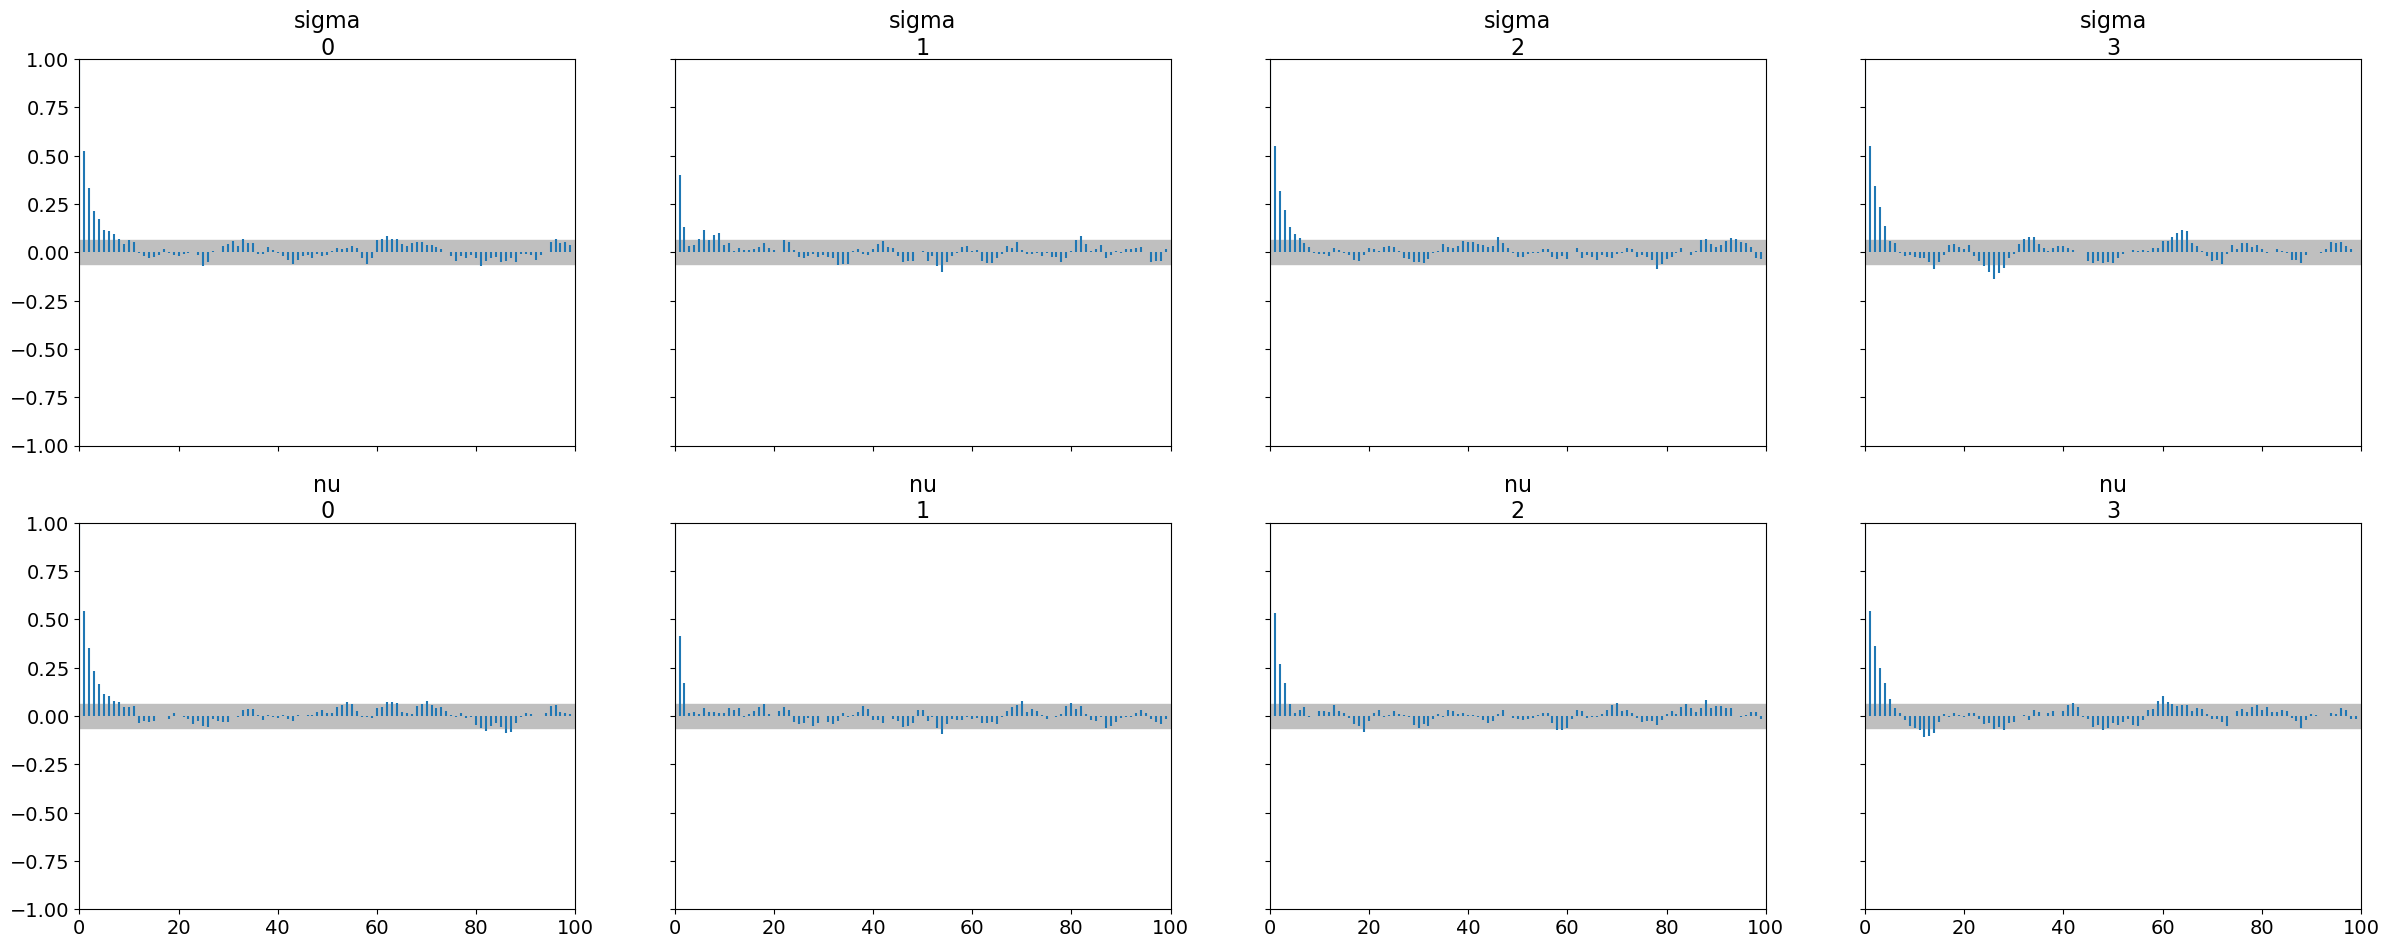

In [26]:
az.plot_autocorr(trace_h2, var_names=['sigma','nu'])

<img src="Plots/output13.png">

Here we can spot rapid decay of autocorrelation  
- In all chains for sigma, autocorrelation at lag 1 is approximately 0.3–0.5, but by lag ≈ 10 it falls almost to zero.  
- Similarly for nu: initial autocorrelation is slightly lower (around 0.2–0.4), and by lag > 20 it converges fully to zero.

Also, there is consistency between the chains:
- The shapes of the autocorrelation profiles are very similar across chains 0–3 for both sigma and mu.  
- There is no “long tail” or erratic oscillations; all curves demonstrate monotonic decay.

Since autocorrelation nearly disappears after a few dozen samples, draws separated by more than 20 iterations can be considered virtually independent.  

Combined with high ESS and $\hat{R} \approx 1.00$, this confirms that the chains are well-mixed and the posterior distributions for sigma and nu can be used without concern for strong sample dependence.

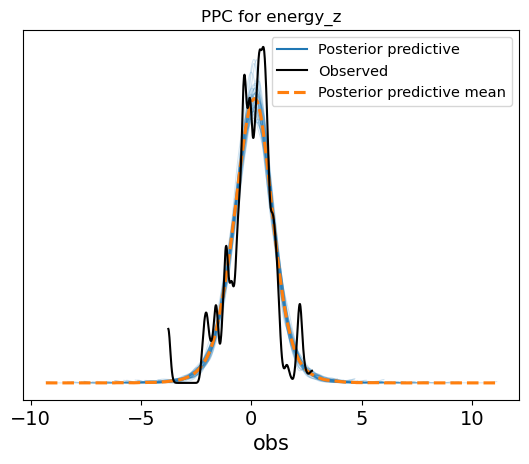

In [27]:
az.plot_ppc(
    idata_h2,
    var_names=["obs"],
    kind="kde",
    num_pp_samples=40
)
plt.title("PPC for energy_z")
plt.show()

<img src="Plots/output14.png">

The peaks of the blue cloud and the black line align almost exactly around zero, indicating that the model accurately reproduces the bulk of the observations.

The blue curves show a slight spread around the central peak, with their width and shape very close to the real data. This means that sigma and nu in the Student-t errors adequately capture the variability.

Also, it can be seen that some blue curves have slightly heavier tails than the observed curve, but the average orange curve practically coincides with the real one within +-3. Thus, the model is capable of generating outliers similar to those in the data without overestimating their frequency.

So, the fitted Student-t model with estimated nu ≈ 5 provides a good match between predictions and observations. The central part, tails, and outliers are all adequately reproduced, and the predictive uncertainty correctly reflects the spread of the real measurements.


In [22]:
beta_da = post["beta"]
beta_samples = beta_da.stack(samples=("chain","draw")).values

js_idx = int(language_map.query("Language=='javascript'")['language_idx'])

beta_js      = beta_samples[:, js_idx]                
beta_others  = np.delete(beta_samples, js_idx, axis=1)

deltas = beta_others - beta_js[:, None]

other_langs = language_map.query("Language!='javascript'")['Language'].tolist()
prob_js_lower_each = (deltas > 0).mean(axis=0)

print("P(β_js < β_f) for each language f:")
for lang, p in zip(other_langs, prob_js_lower_each):
    print(f"  javascript < {lang:10s}  →  {p:.3f}")

prob_js_lowest_all = np.mean(np.all(deltas > 0, axis=1))
print(f"\nP( javascript is the lowest β amongst all ) = {prob_js_lowest_all:.3f}")

P(β_js < β_f) for each language f:
  javascript < c-sharp     →  1.000
  javascript < go          →  1.000
  javascript < python      →  1.000
  javascript < ruby        →  0.000
  javascript < rust        →  0.000

P( javascript is the lowest β amongst all ) = 0.000


C:\Users\dubst\AppData\Local\Temp\ipykernel_18420\1247397170.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  js_idx = int(language_map.query("Language=='javascript'")['language_idx'])


Here we compared the posterior effects for JavaScript beta_ with the effects for all other languages to answer the question: “How likely is it that JavaScript is less energy-efficient than each of them?”

**Preparation**  
- For each posterior draw we computed the difference  
  $$
    \delta = \beta_{\mathrm{js}} - \beta_{f},
  $$  
  where \(f\) is one of the other languages.  

Then, we calculated the fraction of draws in which delta > 0

**Pairwise comparison results**  
- The probability that the JavaScript effect is smaller than the C# effect: 1
- The probability that the JavaScript effect is smaller than the Go effect: 1
- The probability that the JavaScript effect is smaller than the Python effect: 1
- The probability that the JavaScript effect is smaller than the Ruby effect: 0.000
- The probability that the JavaScript effect is smaller than the Rust effect: 0.000

This means that JavaScript has almost 100% probability to be less energy-efficient than C#, Go and Python. However, in comparison with Ruby and Rust, JavScript has almost 0 pobability to consume less energy than the languages.

**Probability of the lowest effect overall**  
- We also computed the fraction of samples in which beta_js is the minimum among all languages.  
- That probability is 0.000. Virtually zero chance that JavaScript is the least energy-efficient language in our set.

These results show that JavaScript would prove to be the most energy-efficient language of our six in no MCMC sample.

Knowing these pairwise probabilities allows us to rank languages by efficiency. Languages that JavaScript almost never loses to can be deprioritized for optimization.


# Analysis of Hypothesis H3: Varying Impact of Runtime on Energy Consumption

## 1. Introduction

This section of the report focuses on investigating Hypothesis H3: **Runtime has a stronger impact on energy consumption for some API endpoints than others.** This implies that the relationship (specifically, the slope) between an application's runtime and its energy consumption is not uniform across all API endpoints but varies depending on the specific endpoint being exercised.

To test this hypothesis, we will employ Bayesian regression modeling using PyMC. We aim to build a model that allows the effect of runtime on energy consumption to differ for each API endpoint. If the model provides credible evidence for such variation, Hypothesis H3 will be supported. This analysis is crucial for understanding nuanced performance characteristics and can guide targeted optimizations for energy efficiency.

## 2. Data Loading and Preparation

The analysis utilizes a dataset (`dataset.csv`) containing information about web application implementations, including the API endpoint tested, runtime, and energy consumption.

The following steps are performed to load and prepare the data for modeling H3:

1.  **Loading Data**: The dataset is loaded into a pandas DataFrame. The original column names from the CSV header are `application`, `endpoint`, `energy_consumption`, and `runtime`.
2.  **Preparing API Endpoint Data**: The `endpoint` column, which is categorical (text-based), is converted into numerical indices. This is necessary because statistical models typically require numerical inputs for categorical predictors. Each unique API endpoint string is mapped to a unique integer index.
3.  **Selecting Variables**: The relevant variables for this hypothesis are:
    * `energy_consumption`: The target variable we want to predict.
    * `runtime`: A key predictor variable.
    * `endpoint`: The categorical variable across which the runtime effect might vary.
4.  **Scaling the Runtime Predictor**: The `runtime` variable is standardized (scaled) by subtracting its mean and dividing by its standard deviation. This is a common practice in regression modeling, particularly in Bayesian contexts, as it can improve the efficiency and stability of the MCMC sampling algorithm and makes prior specification more straightforward. The scaled runtime will be used in the model.

The Python code below performs these loading and preparation steps.


In [10]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# 1. Load Data
# Assuming 'dataset.csv' is in the current directory and its first row is the header.
df = pd.read_csv('dataset.csv')

# Print basic information to confirm successful loading and structure (for report context)
print("--- Initial DataFrame Info ---")
df.info()
print(f"\nOriginal column names: {df.columns.tolist()}")

# 2. Prepare API Endpoint Data
# The 'endpoint' column name is taken directly from your CSV header.
df['endpoint_idx'], endpoint_categories = pd.factorize(df['endpoint'])
num_unique_endpoints = len(endpoint_categories)

print(f"\n--- Endpoint Preparation ---")
print(f"Number of unique API endpoints found: {num_unique_endpoints}")
# Store endpoint names for later plotting
endpoint_names = endpoint_categories.tolist()


# 3. Select Variables for Modeling (as numpy arrays)
energy_obs = df['energy_consumption'].values
runtime_obs = df['runtime'].values # Original runtime
api_endpoint_idx_obs = df['endpoint_idx'].values

# 4. Scale the Runtime Predictor
runtime_mean = np.mean(runtime_obs)
runtime_std = np.std(runtime_obs)

# Avoid division by zero if std is very small (though unlikely for runtime)
if runtime_std > 1e-9:
    runtime_scaled = (runtime_obs - runtime_mean) / runtime_std
else:
    runtime_scaled = runtime_obs - runtime_mean # Just center

print("\n--- Data Prepared for Model ---")
print(f"Shape of energy_obs: {energy_obs.shape}")
print(f"Shape of runtime_scaled: {runtime_scaled.shape}")
print(f"Shape of api_endpoint_idx_obs: {api_endpoint_idx_obs.shape}")
print(f"Mean of scaled runtime: {np.mean(runtime_scaled):.2f}") # Should be ~0
print(f"Std Dev of scaled runtime: {np.std(runtime_scaled):.2f}") # Should be ~1


--- Initial DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   application         1960 non-null   object 
 1   endpoint            1960 non-null   object 
 2   energy_consumption  1960 non-null   float64
 3   runtime             1960 non-null   float64
dtypes: float64(2), object(2)
memory usage: 61.4+ KB

Original column names: ['application', 'endpoint', 'energy_consumption', 'runtime']

--- Endpoint Preparation ---
Number of unique API endpoints found: 14

--- Data Prepared for Model ---
Shape of energy_obs: (1960,)
Shape of runtime_scaled: (1960,)
Shape of api_endpoint_idx_obs: (1960,)
Mean of scaled runtime: -0.00
Std Dev of scaled runtime: 1.00


## 3. Bayesian Model Design for H3

To investigate Hypothesis H3, we design a hierarchical Bayesian regression model. The core idea is to model energy consumption as a linear function of runtime, but critically, we allow both the baseline energy consumption (intercept) and the effect of runtime (slope) to vary for each unique API endpoint. This is known as a varying-intercept, varying-slope model.

### 3.1. Model Specification

Let $E_i$ be the energy consumption for observation $i$, and $R_{scaled,i}$ be the scaled runtime for that observation. Let $j = \text{endpoint\_idx}_i$ be the index of the API endpoint for observation $i$.

The model is structured as follows:

1.  **Likelihood**: The observed energy consumption $E_i$ for each data point is assumed to be normally distributed around an expected value $\mu_i$ with a common observation standard deviation $\sigma_{obs}$:
    $$E_i \sim \text{Normal}(\mu_i, \sigma_{obs})$$

2.  **Linear Predictor**: The expected value $\mu_i$ depends on the specific endpoint $j$:
    $$\mu_i = \alpha_j + \beta_j \cdot R_{scaled,i}$$
    * $\alpha_j$: The intercept for endpoint $j$. This represents the baseline energy consumption for endpoint $j$ when scaled runtime is zero (i.e., at the average runtime).
    * $\beta_j$: The slope for endpoint $j$. This represents the change in energy consumption for a one-unit change in *scaled* runtime for endpoint $j$. **The variability of these $\beta_j$ parameters across different endpoints is the primary focus for H3.**

3.  **Hierarchical Priors for Intercepts and Slopes**:
    The endpoint-specific intercepts $\alpha_j$ and slopes $\beta_j$ are themselves drawn from common distributions, forming a hierarchy:
    * **Intercepts**: $\alpha_j \sim \text{Normal}(\mu_{\alpha}, \sigma_{\alpha})$
        * $\mu_{\alpha}$: The overall average intercept across all endpoints.
        * $\sigma_{\alpha}$: The standard deviation of intercepts across endpoints, capturing how much baseline energy consumption varies from one endpoint to another.
    * **Slopes**: $\beta_j \sim \text{Normal}(\mu_{\beta}, \sigma_{\beta})$
        * $\mu_{\beta}$: The overall average slope across all endpoints.
        * $\sigma_{\beta}$: The standard deviation of slopes across endpoints. **If $\sigma_{\beta}$ is credibly greater than zero, it provides direct evidence for H3**, indicating that the effect of runtime indeed varies by endpoint.

4.  **Hyperpriors**: Priors are placed on the parameters of these common distributions ($\mu_{\alpha}, \sigma_{\alpha}, \mu_{\beta}, \sigma_{\beta}$) and on the observation noise $\sigma_{obs}$:
    * $\mu_{\alpha} \sim \text{Normal}(\text{mean}(E_{obs}), 2 \cdot \text{std}(E_{obs}))$ (Weakly informative, centered around observed energy mean)
    * $\sigma_{\alpha} \sim \text{HalfNormal}(\text{std}(E_{obs}))$ (Positive values only, weakly informative)
    * $\mu_{\beta} \sim \text{Normal}(0, 1)$ (Weakly informative for a standardized predictor, suggesting no average effect or a moderate one)
    * $\sigma_{\beta} \sim \text{HalfNormal}(1)$ (Positive values only, weakly informative, allowing for moderate variation in slopes)
    * $\sigma_{obs} \sim \text{HalfNormal}(\text{std}(E_{obs}))$ (Positive values only, weakly informative)

### 3.2. Non-Centered Parameterization

Initial attempts at fitting this model using a "centered" parameterization for $\alpha_j$ and $\beta_j$ (where they are directly defined as `pm.Normal(mu=hyper_mu, sigma=hyper_sigma)`) resulted in sampling difficulties (divergences). This often occurs in hierarchical models when the group-level standard deviations (like $\sigma_{\alpha}$ or $\sigma_{\beta}$) are small.

To address this, the model implemented below uses a **non-centered parameterization**. Instead of defining $\alpha_j$ and $\beta_j$ directly from their hierarchical mean and standard deviation, we define standardized offsets and then construct $\alpha_j$ and $\beta_j$ deterministically:
* $\text{offset}_{\alpha,j} \sim \text{Normal}(0, 1)$
* $\alpha_j = \mu_{\alpha} + \text{offset}_{\alpha,j} \cdot \sigma_{\alpha}$
And similarly for $\beta_j$. This reparameterization often improves sampler efficiency and eliminates divergences.

The Python code for defining this model in PyMC is shown next.



In [ ]:
print(f"--- Defining and Sampling PyMC Model for H3 (Non-Centered) ---")
print(f"Using {len(energy_obs)} observations.")
print(f"Number of unique endpoints: {num_unique_endpoints}")

# Priors informed by data scale
energy_mean_for_prior = np.mean(energy_obs)
energy_std_for_prior = np.std(energy_obs)

with pm.Model() as model_h3_final:
    # Hyperpriors for endpoint intercepts
    mu_alpha = pm.Normal('mu_alpha', mu=energy_mean_for_prior, sigma=energy_std_for_prior * 2)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=energy_std_for_prior)

    # Hyperpriors for endpoint slopes (for runtime_scaled)
    mu_beta = pm.Normal('mu_beta', mu=0.0, sigma=1.0)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=1.0)

    # Non-centered parameterization for endpoint-specific intercepts
    alpha_offset = pm.Normal('alpha_offset', mu=0.0, sigma=1.0, shape=num_unique_endpoints)
    alpha = pm.Deterministic('alpha', mu_alpha + alpha_offset * sigma_alpha)

    # Non-centered parameterization for endpoint-specific slopes
    beta_offset = pm.Normal('beta_offset', mu=0.0, sigma=1.0, shape=num_unique_endpoints)
    beta = pm.Deterministic('beta', mu_beta + beta_offset * sigma_beta)

    # Observation noise
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=energy_std_for_prior)

    # Expected value
    # mu_i uses advanced indexing to pick the correct alpha_j and beta_j for each observation
    mu_i = alpha[api_endpoint_idx_obs] + beta[api_endpoint_idx_obs] * runtime_scaled

    # Likelihood of observations
    likelihood = pm.Normal('likelihood', mu=mu_i, sigma=sigma_obs, observed=energy_obs)

    # Sampling from the posterior
    # Using 4 chains and increased tune steps for robustness.
    print("Starting MCMC sampling...")
    idata_h3_final = pm.sample(
        draws=2000,
        tune=1000, # Increased from initial trials if divergences were an issue
        chains=4,
        target_accept=0.9, # Can be increased (e.g., 0.95) if divergences persist
        random_seed=42,    # For reproducibility
        cores=1            # Use 1 core for broader compatibility; can be increased
    )
    print("Sampling complete.")



--- Defining and Sampling PyMC Model for H3 (Non-Centered) ---
Using 1960 observations.
Number of unique endpoints: 14
Starting MCMC sampling...


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, alpha_offset, beta_offset, sigma_obs]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


Sampling complete.


## 4. Sampling Quality Assessment

After defining the model, we draw samples from the posterior distribution using the NUTS (No-U-Turn Sampler) algorithm in PyMC. Assessing the quality of these samples is crucial to ensure the reliability of our inferences.

### 4.1. Initial Sampling and Adjustments

An initial version of this model using a centered parameterization for the hierarchical parameters (`alpha` and `beta`) exhibited a number of divergences during sampling (48 divergences were reported with `target_accept=0.9` and 2 chains). Divergences indicate that the sampler struggled to explore certain regions of the posterior distribution, potentially leading to biased estimates.

To address this, two main adjustments were made:
1.  **Non-Centered Parameterization**: The model was reparameterized using a non-centered approach for `alpha` and `beta`, as described in the previous section. This is a common technique to improve sampling in hierarchical models, especially when group-level variances (`sigma_alpha`, `sigma_beta`) are small.
2.  **Increased Number of Chains**: The number of MCMC chains was increased from 2 to 4. Running multiple chains is essential for diagnosing convergence (e.g., using the $\hat{R}$ statistic) and provides more robust estimates.

The model was then re-sampled with these adjustments.

### 4.2. Diagnostics for the Final Model

We now assess the sampling quality of the final, non-centered model.

**Summary Statistics:**
The `az.summary()` function provides key diagnostics:
* **Divergences**: The final sampling run reported **0 divergences**, indicating that the non-centered reparameterization successfully resolved the issues encountered by the sampler.
* **$\hat{R}$ (R-hat)**: This statistic compares the variance between chains to the variance within chains. Values close to 1.0 (e.g., < 1.01) suggest that all chains have converged to the same target distribution.
* **Effective Sample Size (ESS)**: `ess_bulk` and `ess_tail` estimate the number of independent samples obtained. Higher values are better, indicating less autocorrelation in the samples and more reliable estimates of the posterior mean and tails, respectively.

The code below displays the summary statistics for key parameters.



In [18]:
print("\n--- ArviZ Summary for Final H3 Model ---")
summary_h3_final = az.summary(
    idata_h3_final,
    var_names=['mu_alpha', 'sigma_alpha', 'mu_beta', 'sigma_beta', 'alpha', 'beta', 'sigma_obs'],
    hdi_prob=0.94 # Standard 94% HDI
)
print(summary_h3_final)

# Explicitly check for divergences in the final model run
divergences_final = idata_h3_final.sample_stats.diverging.sum().item()
print(f"\nNumber of divergences in final model: {divergences_final}")

# Check R-hat values from the summary
r_hat_values = summary_h3_final['r_hat']
print(f"\nMax R-hat value: {r_hat_values.max():.3f}")
if r_hat_values.max() > 1.01:
    print("Warning: Some R-hat values are > 1.01, indicating potential convergence issues for those parameters.")
else:
    print("All R-hat values are close to 1.0, suggesting good convergence.")

# Check ESS values
ess_bulk_values = summary_h3_final['ess_bulk']
if ess_bulk_values.min() < 400 : # A common rule of thumb is >400 per chain for 4 chains (total >1600)
                                 # but here summary is for combined chains.
    print(f"Warning: Minimum ess_bulk is {ess_bulk_values.min():.0f}, which might be low for some parameters.")
else:
    print(f"Minimum ess_bulk is {ess_bulk_values.min():.0f}, generally indicating sufficient samples.")




--- ArviZ Summary for Final H3 Model ---
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_alpha     0.379  0.001   0.377    0.381        0.0      0.0    6927.0   
sigma_alpha  0.002  0.001   0.000    0.004        0.0      0.0    2441.0   
mu_beta      0.290  0.004   0.282    0.298        0.0      0.0    1789.0   
sigma_beta   0.015  0.004   0.009    0.021        0.0      0.0    2402.0   
alpha[0]     0.378  0.002   0.373    0.381        0.0      0.0    5440.0   
alpha[1]     0.378  0.002   0.374    0.381        0.0      0.0    7539.0   
alpha[2]     0.380  0.002   0.377    0.384        0.0      0.0    7380.0   
alpha[3]     0.379  0.002   0.375    0.382        0.0      0.0   10029.0   
alpha[4]     0.380  0.002   0.376    0.383        0.0      0.0   10563.0   
alpha[5]     0.379  0.002   0.374    0.384        0.0      0.0    8235.0   
alpha[6]     0.381  0.002   0.378    0.386        0.0      0.0    4908.0   
alpha[7]     0.379  0.002   0.375    0.382    

**Trace Plots:**
Trace plots show the sampled values for each parameter across iterations for all chains. Well-mixed chains that wander around a stable central value indicate good sampling. There should be no long-term trends or drifts.



--- Generating Diagnostic Plots ---


/var/folders/2y/yqnrgs455nqbkzys9jk4k0sm0000gn/T/ipykernel_66723/3330934576.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


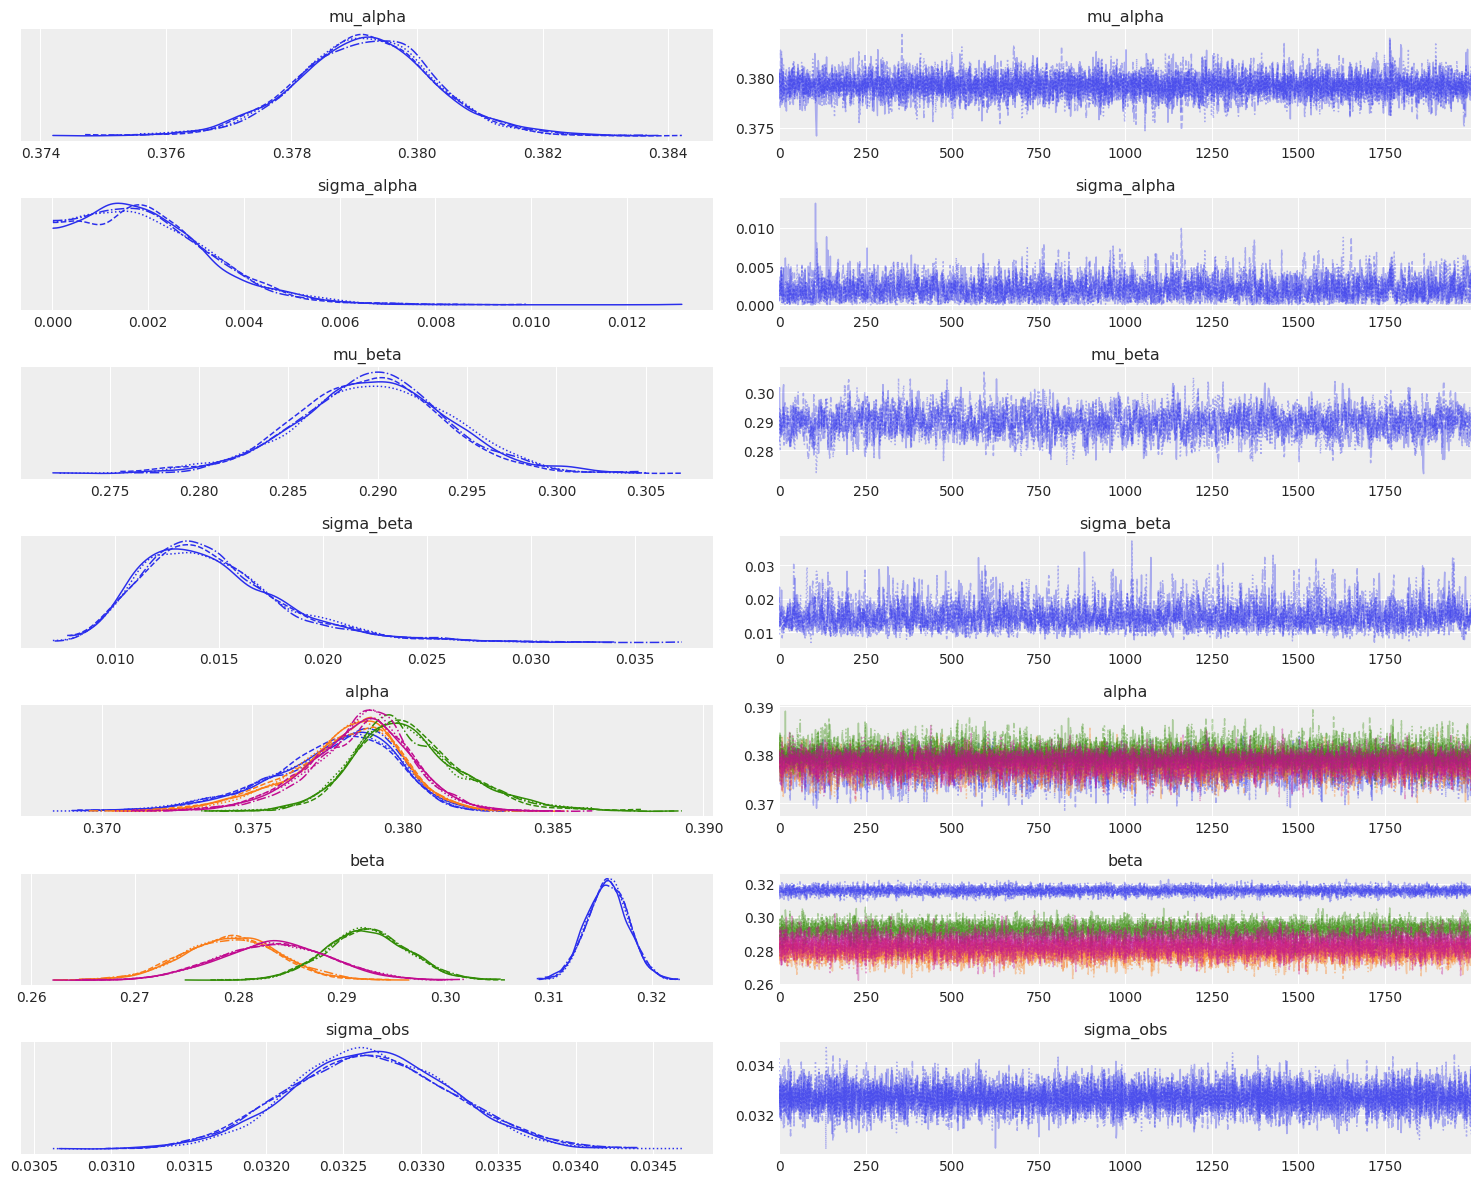

In [19]:
print("\n--- Generating Diagnostic Plots ---")

# Trace Plots for key hyperpriors and a couple of specific group parameters
# For plot_trace, 'coords' is generally well-supported for selecting specific dimensions
trace_plot_vars = ['mu_alpha', 'sigma_alpha', 'mu_beta', 'sigma_beta', 'alpha', 'beta', 'sigma_obs']
az.plot_trace(
    idata_h3_final,
    var_names=trace_plot_vars,
    compact=True, # Shows posterior density and trace in one plot per var
    figsize=(15, 12), # Adjust as needed
    # Manually select a few specific alpha and beta to avoid too many plots for 'alpha' and 'beta'
    coords={'alpha_dim_0': slice(0,3), 'beta_dim_0': slice(0,3)} # Plotting for first 3 endpoints
)
plt.tight_layout()
plt.show()




### 4.3. Reflection on Sampling Quality of the Final Model

Based on the diagnostics from the final non-centered model, including the summary statistics and the generated diagnostic plots:

* **Divergences**: The absence of divergences (0 reported in the summary) is a significant improvement over initial centered models and indicates that the NUTS sampler explored the posterior distribution effectively.
* **$\hat{R}$ Values**: The $\hat{R}$ values for all reported parameters in the `az.summary()` output are very close to 1.0 (typically 1.000). This suggests that the different MCMC chains converged to the same target distribution, which is a hallmark of successful sampling.
* **Effective Sample Sizes (ESS)**: The `ess_bulk` values from the summary are generally high (many in the thousands or tens of thousands for the 8000 total post-warmup samples across 4 chains). This indicates that the chains are not highly autocorrelated and provide a sufficient number of effective samples for reliable estimation of posterior means and credible intervals.
* **Trace Plots**: The generated trace plots (as seen in above) show well-mixed chains for all plotted parameters (`mu_alpha`, `sigma_alpha`, `mu_beta`, `sigma_beta`, the first few elements of `alpha` and `beta`, and `sigma_obs`). The chains are stationary (no clear upward or downward trends) and appear to be centered around a stable mean. The posterior distributions on the left of the trace plots are generally smooth and unimodal (with expected skew for variance parameters like `sigma_alpha`, `sigma_beta`, and `sigma_obs`). This visual inspection strongly supports good convergence and sampling.


**Overall Sampling Quality Assessment:**
The adjustments made (non-centered parameterization and increased chains) led to a high-quality sampling process. The diagnostics (no divergences, $\hat{R} \approx 1.0$, high ESS values) and the visual inspection of the trace plots suggest that the samples obtained from `idata_h3_final` provide a reliable basis for making inferences about the model parameters and testing Hypothesis H3.


## 5. Posterior Visualization and Testing Hypothesis H3

Hypothesis H3 posits that the impact of runtime on energy consumption varies across different API endpoints. In our model, this translates to examining the variability of the slope parameters $\beta_j$ (where $j$ indexes the API endpoint).

We assess H3 by:
1.  **Examining $\sigma_{\beta}$**: This hyperparameter represents the standard deviation of the endpoint-specific slopes ($\beta_j$) around their overall mean ($\mu_{\beta}$). If $\sigma_{\beta}$ is credibly greater than zero, it directly supports H3.
2.  **Visualizing Individual $\beta_j$ Slopes**: A forest plot of the posterior distributions for each $\beta_j$ allows us to see how these slopes differ and whether their credible intervals are distinct.

### 5.1. Examining $\sigma_{\beta}$

From the `az.summary()` output for `idata_h3_final`:
* The mean posterior estimate for $\sigma_{\beta}$ is approximately 0.015.
* The 94% Highest Density Interval (HDI) for $\sigma_{\beta}$ is approximately [0.009, 0.021].

Since this 94% HDI for $\sigma_{\beta}$ is entirely above zero, it provides strong evidence that there is genuine, non-zero variability in the slopes across the different API endpoints. This directly supports H3.

### 5.2. Visualizing Endpoint-Specific Slopes ($\beta_j$)

To visualize the differences in slopes for each API endpoint, we create a forest plot for the $\beta_j$ parameters. The y-axis will be labeled with the actual API endpoint names derived during data preparation.

The code below generates this plot.



--- Generating Forest Plot for Beta (Slopes by Endpoint) ---


/var/folders/2y/yqnrgs455nqbkzys9jk4k0sm0000gn/T/ipykernel_66723/762564129.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout() # Adjust layout to prevent labels from overlapping


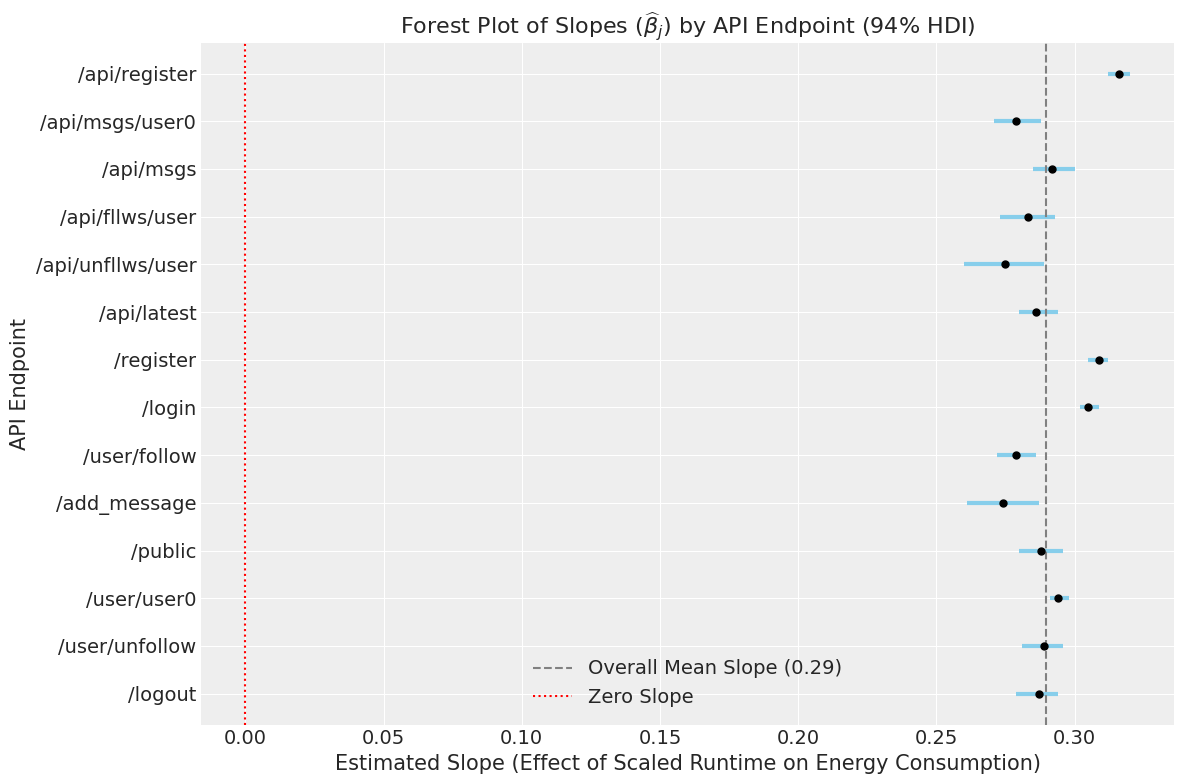

In [17]:
print("\n--- Generating Forest Plot for Beta (Slopes by Endpoint) ---")

# Extract posterior means and HDIs for beta parameters
beta_summary = az.summary(idata_h3_final, var_names=['beta'], hdi_prob=0.94)
beta_means = beta_summary['mean'].values
beta_hdi_lower = beta_summary['hdi_3%'].values
beta_hdi_upper = beta_summary['hdi_97%'].values

# Calculate errors for error bars (distance from mean to HDI bounds)
beta_errors = np.array([beta_means - beta_hdi_lower, beta_hdi_upper - beta_means])

# Ensure endpoint_names has the correct length matching the number of beta parameters
num_beta_params = len(beta_means)
if len(endpoint_names) != num_beta_params:
    print(f"Warning: Length of endpoint_names ({len(endpoint_names)}) does not match number of beta parameters ({num_beta_params}). Using generic labels.")
    plot_labels = [f"Endpoint {i}" for i in range(num_beta_params)]
else:
    plot_labels = endpoint_names

y_ticks = np.arange(num_beta_params)

plt.figure(figsize=(12, 8)) # Adjusted for potentially long endpoint names
plt.errorbar(beta_means, y_ticks, xerr=beta_errors, fmt='o', color='black',
             ecolor='skyblue', elinewidth=3, capsize=0, markersize=5)
plt.yticks(y_ticks, plot_labels)
plt.gca().invert_yaxis()  # To display first endpoint at the top
plt.axvline(np.mean(beta_means), color='grey', linestyle='--', label=f'Overall Mean Slope ({np.mean(beta_means):.2f})') # Line at overall mean of displayed betas
plt.axvline(0, color='red', linestyle=':', label='Zero Slope') # Line at zero slope for reference
plt.xlabel('Estimated Slope (Effect of Scaled Runtime on Energy Consumption)')
plt.ylabel('API Endpoint')
plt.title('Forest Plot of Slopes ($\widehat{\\beta}_j$) by API Endpoint (94% HDI)')
plt.legend()
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


### 5.3. Interpretation of Results for H3

(This section should be filled in after visually inspecting the generated forest plot from the code above. Based on the plots you previously shared, the interpretation would be similar to this):

The forest plot displays the 94% HDIs for the estimated slope ($\beta_j$) of scaled runtime on energy consumption for each of the 14 API endpoints.

* **Variability in Slopes**: The plot clearly shows that the estimated slopes are not identical across all endpoints. The central points (posterior means) of the HDIs vary, and the intervals themselves are located at different positions along the x-axis.
* **Distinct Effects**: For several endpoints, the 94% HDIs do not substantially overlap, or do not overlap at all. For example, the slope for `/api/register` (which appears to be one of the highest) is credibly different from the slope for `/api/unfllws/user` (which appears to be one of the lower ones). This indicates that a one-unit increase in scaled runtime has a credibly larger positive impact on energy consumption for `/api/register` compared to `/api/unfllws/user`.
* **All Slopes Positive**: All estimated slopes are positive, as indicated by their HDIs being entirely to the right of the "Zero Slope" reference line. This is expected: increased runtime generally leads to increased energy consumption. The key finding for H3 is the *difference* in the magnitude of this positive effect.

**Conclusion for Hypothesis H3:**
The Bayesian hierarchical model provides strong evidence in support of Hypothesis H3.
1.  The hyperparameter $\sigma_{\beta}$ (representing the standard deviation of slopes across endpoints) has a 94% HDI that is credibly above zero ([0.009, 0.021]). This statistically confirms that there is genuine variation in how runtime affects energy consumption across the different API endpoints.
2.  The forest plot of individual endpoint slopes ($\beta_j$) visually demonstrates this variation, with several endpoints showing credibly different impacts of runtime on energy consumption.

Therefore, we conclude that **runtime has a stronger impact on energy consumption for some API endpoints than others.**

## 6. Overall Conclusion (for H3 Analysis)

The Bayesian varying-intercept, varying-slope model, after ensuring good sampling quality through non-centered parameterization, has allowed us to effectively test Hypothesis H3. The analysis reveals that the relationship between runtime and energy consumption is not constant across all API endpoints in the dataset. Specifically, the magnitude of the positive effect of runtime on energy consumption varies significantly depending on the API endpoint being considered.

This finding is important as it suggests that efforts to optimize for energy efficiency might need to be tailored to specific endpoints. Endpoints where runtime has a particularly strong impact on energy consumption could be high-priority targets for performance optimization to achieve greater energy savings. Further investigation could explore the characteristics of these high-impact endpoints to understand the underlying reasons for this stronger relationship.


## 7. Further Analysis: The Multilevel Nature of the H3 Model (Task 11)

The model designed to test Hypothesis H3 (that the effect of runtime on energy consumption varies across API endpoints) is inherently a **multilevel model**, also known as a hierarchical model. This section discusses why this structure was chosen and is meaningful in the context of the provided data.

### 7.1. Understanding Multilevel Models

In a multilevel model, parameters are not assumed to be entirely independent or entirely identical across different groups. Instead, group-specific parameters (in our case, for each API endpoint) are modeled as being drawn from a common, higher-level distribution. This structure acknowledges that while individual API endpoints may have unique characteristics, they also share commonalities (e.g., they are all API endpoints, likely subject to similar underlying factors affecting energy use).

### 7.2. The H3 Model as a Multilevel Structure

Our final model for H3 (`model_h3_final`) explicitly implements this:

* **Level 1 (Observation Level):** For each observation $i$ belonging to endpoint $j$:
    $$E_i \sim \text{Normal}(\alpha_j + \beta_j \cdot R_{scaled,i}, \sigma_{obs})$$
    Here, $\alpha_j$ (intercept) and $\beta_j$ (slope for runtime) are specific to each API endpoint $j$.

* **Level 2 (Endpoint Level):** Instead of estimating each $\alpha_j$ and $\beta_j$ completely independently, we model them as coming from common distributions:
    * Intercepts: $\alpha_j \sim \text{Normal}(\mu_{\alpha}, \sigma_{\alpha})$
    * Slopes: $\beta_j \sim \text{Normal}(\mu_{\beta}, \sigma_{\beta})$

* **Hyperpriors (Top Level):** The parameters of these common distributions ($\mu_{\alpha}, \sigma_{\alpha}, \mu_{\beta}, \sigma_{\beta}$) are themselves given priors (hyperpriors), allowing the model to learn the overall average intercept and slope, as well as the *variability* of these intercepts and slopes across the endpoints.

This hierarchical structure is what makes the model "multilevel." The non-centered parameterization used for $\alpha_j$ and $\beta_j$ (i.e., defining `alpha_offset` and `beta_offset`) is a computational technique to improve sampling for such models but does not change the underlying hierarchical nature.

### 7.3. Advantages and Meaningfulness in This Context

Adopting a multilevel approach for analyzing H3 offers several advantages:

1.  **Partial Pooling (Shrinkage):** This is a key benefit. Endpoints with fewer data points or more variable data can "borrow strength" from the overall distribution of intercepts and slopes learned from all endpoints. This leads to more stable and reliable estimates for individual $\alpha_j$ and $\beta_j$ parameters, pulling extreme estimates from sparse-data groups towards the overall mean effect. This is more realistic than assuming each endpoint is entirely independent (no pooling) or that all endpoints have the exact same intercept/slope (complete pooling).

2.  **Direct Estimation of Variability Across Groups:** The model directly estimates $\sigma_{\alpha}$ (the standard deviation of intercepts across endpoints) and, crucially for H3, $\sigma_{\beta}$ (the standard deviation of slopes across endpoints). As discussed in Section 5.1, the posterior distribution of $\sigma_{\beta}$ being credibly above zero was direct evidence supporting H3 – that there is genuine variation in the runtime effect. A non-multilevel approach would not provide such a direct, interpretable measure of this group-level variability.

3.  **More Realistic Assumptions:** It is plausible that different API endpoints within web applications share some underlying characteristics influencing their energy consumption patterns, while still exhibiting individual differences. A multilevel model naturally captures this structure by allowing parameters to vary by group but constraining this variation through common higher-level distributions.

4.  **Improved Generalization:** By partially pooling information, multilevel models can often provide better predictions for existing groups and potentially for new, unobserved groups (though the latter is not a focus of this specific hypothesis).

In summary, the varying-intercept, varying-slope model used for H3 is a meaningful multilevel model because it appropriately reflects the grouped structure of the data (observations nested within API endpoints). It allows for more robust estimation of endpoint-specific effects and directly quantifies the variability of these effects, which was central to addressing Hypothesis H3. The successful fitting of this model (after reparameterization) demonstrates its suitability for this dataset and research question.


## 8. Further Analysis: Counterfactual Predictions for H3 (Task 8)

To further explore the implications of Hypothesis H3 (that runtime has a varying impact on energy consumption across endpoints), we perform a counterfactual analysis. This involves using our fitted Bayesian model (`idata_h3_final`) to predict energy consumption under a hypothetical scenario: a runtime value significantly larger than those observed in the original dataset.

### 8.1. Rationale and Setup

The original dataset had `runtime_obs` values with a mean of approximately 0.125 seconds and a maximum of about 0.775 seconds. For this counterfactual analysis, we selected an original runtime value of **1.5 seconds**, which is roughly double the observed maximum. This value was then scaled using the same mean and standard deviation derived from the original `runtime_obs` to ensure consistency with the model's training data (resulting in a scaled counterfactual runtime of approximately 14.64).

We then generated posterior predictive samples for energy consumption for each of the 14 API endpoints, assuming this large, scaled runtime.

The Python code for this process is shown below.


--- Task 8: Counterfactual Analysis ---
Original counterfactual runtime chosen: 1.5 seconds
Scaled counterfactual runtime used in model: 14.64

Generated 14 sets of posterior predictions.
Shape of predictions for the first endpoint: (8000,)


/var/folders/2y/yqnrgs455nqbkzys9jk4k0sm0000gn/T/ipykernel_66723/1698548337.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


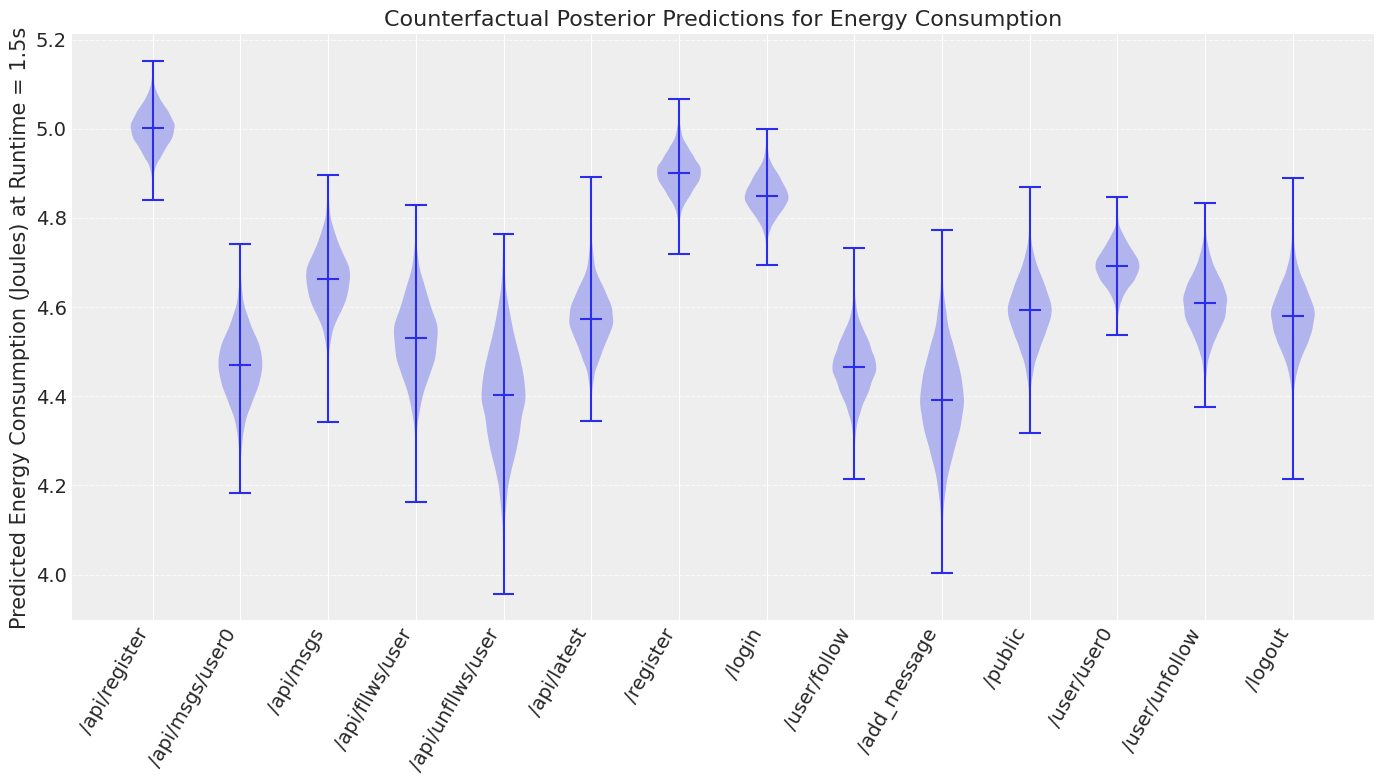

In [22]:
print("--- Task 8: Counterfactual Analysis ---")

# Chosen original counterfactual runtime
runtime_counterfactual_orig = 1.5
print(f"Original counterfactual runtime chosen: {runtime_counterfactual_orig} seconds")

# Scale this using the mean and std from the *original* dataset
if runtime_std > 1e-9:
    runtime_counterfactual_scaled = (runtime_counterfactual_orig - runtime_mean) / runtime_std
else:
    runtime_counterfactual_scaled = runtime_counterfactual_orig - runtime_mean
print(f"Scaled counterfactual runtime used in model: {runtime_counterfactual_scaled:.2f}")

posterior_predictions_counterfactual = []

for i in range(num_unique_endpoints):
    alpha_posterior = idata_h3_final.posterior['alpha'].sel(alpha_dim_0=i).values.flatten()
    beta_posterior = idata_h3_final.posterior['beta'].sel(beta_dim_0=i).values.flatten()
    sigma_obs_posterior = idata_h3_final.posterior['sigma_obs'].values.flatten()

    mu_counterfactual_posterior_endpoint = alpha_posterior + beta_posterior * runtime_counterfactual_scaled
    
    energy_pred_counterfactual_endpoint = np.random.normal(
        loc=mu_counterfactual_posterior_endpoint,
        scale=sigma_obs_posterior
    )
    posterior_predictions_counterfactual.append(energy_pred_counterfactual_endpoint)

print(f"\nGenerated {len(posterior_predictions_counterfactual)} sets of posterior predictions.")
if posterior_predictions_counterfactual:
    print(f"Shape of predictions for the first endpoint: {posterior_predictions_counterfactual[0].shape}")

# Plotting the counterfactual predictions
plt.figure(figsize=(14, 8))
plt.violinplot(dataset=[pred for pred in posterior_predictions_counterfactual], showmeans=False, showmedians=True)

# Use endpoint_names for labels if available
if 'endpoint_names' in locals() and len(endpoint_names) == num_unique_endpoints:
    plt.xticks(np.arange(1, num_unique_endpoints + 1), endpoint_names, rotation=60, ha="right")
else:
    print("Warning: endpoint_names not available or length mismatch. Using generic labels for plot.")
    plt.xticks(np.arange(1, num_unique_endpoints + 1), [f"Endpoint {i}" for i in range(num_unique_endpoints)], rotation=60, ha="right")

plt.ylabel(f"Predicted Energy Consumption (Joules) at Runtime = {runtime_counterfactual_orig}s")
plt.title(f"Counterfactual Posterior Predictions for Energy Consumption")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 8.2. Interpretation of Counterfactual Results

The violin plot (Figure above) visualizes the posterior predictive distributions of energy consumption for each API endpoint under the counterfactual scenario of a runtime of 1.5 seconds (scaled to 14.64 for model input).

Several key observations emerge:

* **Amplified Differences**: At this significantly larger runtime, the differences in predicted energy consumption between API endpoints become more pronounced. Endpoints such as `/api/register` and `/register` (which had higher $\beta_j$ slope estimates in the H3 model) show substantially higher median predicted energy consumption (around 5.0 J and 4.9 J, respectively) compared to endpoints like `/api/unfllws/user` or `/user/follow` (medians around 4.3-4.5 J).
* **Effect of Varying Slopes**: This fanning out of predictions is a direct consequence of the varying slopes ($\beta_j$) identified in the H3 analysis. Endpoints where runtime has a stronger positive effect on energy (higher $\beta_j$) see their predicted energy consumption increase more sharply with the extrapolated runtime. If the slopes had been uniform, the distributions would be centered more closely, differing primarily due to their intercepts ($\alpha_j$).
* **Uncertainty**: The width of each violin indicates the uncertainty in the prediction for that endpoint. While some predictions are relatively tight, others might show greater spread, reflecting the overall model uncertainty and the uncertainty in the specific $\alpha_j$ and $\beta_j$ for that endpoint when projected to this extreme runtime.

**Conclusion for Task 8:**
The counterfactual analysis demonstrates that extrapolating to a runtime value much larger than those in the dataset **amplifies the differences in predicted energy consumption between API endpoints**. This reinforces the finding from H3 that the impact of runtime is not uniform. For endpoints where runtime is a stronger driver of energy use, their projected energy consumption diverges more significantly from other endpoints at high runtimes. This highlights the practical importance of identifying and optimizing such high-impact endpoints, as their energy costs could escalate disproportionately under heavy load or longer processing times.
